# PROYECTO INDIVIDUAL Nº2

***Data Analitycs***

Previo se realizó en análisis de los siguientes puntos:

- Consulta de la documentación API de la página CoinGecko.

- Análisis de los endpoints para la obtención de la data.

- Elección del endpoint /coins/{id}/market_chart/range

**1 - Importación de librerías**

In [1111]:
#Importación de la librerias
import datetime
import requests
import pandas as pd
import csv
import numpy as np
from datetime import timedelta
import seaborn as sns
import matplotlib.pyplot as plt


**2 - Definición de funciones**

2.a - Funciones para transformación de formatos de fechas

In [1112]:
#Definir la función para transformar de string a formato unix timestamp

def timestamp_unix(fecha):
    fecha_dt = datetime.datetime.strptime(fecha, '%d-%m-%Y')
    timestamp_unix = int(fecha_dt.timestamp())

    return timestamp_unix

In [1113]:
# Definir la función para convertir el unix timestamp en una fecha formateada
def conv_fecha(timestamp_millis):
    timestamp_seconds = timestamp_millis / 1000
    fecha = datetime.datetime.fromtimestamp(timestamp_seconds).date()
    fecha_formateada = fecha.strftime('%d-%m-%Y')
    return fecha_formateada

2.b - Función para consulta de enpoint

In [1114]:
#Definir la función para la consulta del endpoint
def get_api(url,unix_from,unix_to):

    params = {
        "vs_currency": "usd",
        "from": unix_from,  # Timestamp de inicio
        "to": unix_to,    # Timestamp de fin
        "precision": "full"
    }

    response = requests.get(url, params=params)     # Realizar la solicitud GET a la API

    if response.status_code == 200:                 # Verificar si la solicitud fue exitosa
        
        data = response.json()                      # Obtener los datos JSON de la respuesta

        return data
        
    else:
        print("Error al realizar la solicitud:", response.status_code)

2.c - Función para creación de data frames

In [1115]:
#Definir función para creación de data frames
def creardf (data0):
    
    df_prices = pd.DataFrame(data0["prices"], columns=["timestamp", "price"])                       # Convertir los datos en un DataFrame
    df_market_caps = pd.DataFrame(data0["market_caps"], columns=["timestamp", "market_cap"])
    df_total_volumes = pd.DataFrame(data0["total_volumes"], columns=["timestamp", "total_volume"])
 
    df = df_prices.merge(df_market_caps, on="timestamp").merge(df_total_volumes, on="timestamp")    # Fusionar los DataFrames en uno 
                                                                                                    # solo usando el campo 'timestamp' como clave
    return df

    del df_prices
    del df_market_caps
    del df_total_volumes

2.d Función Media Móvil Exponencial (EMA)

In [1116]:
#Definir función Media Móvil Exponencial (EMA)
def ema(df,N):

    K = 2 / (N + 1)                                             # Calcular el factor de suavizado K

    return df['price'].ewm(span=N, adjust=False).mean()         # Calcular la EMA utilizando la función ewm().mean()

2.e Función Media Móvil de Convergencia / Divergencia (MACD)

In [1117]:
#Definir función Media Móvil de Convergencia / Divergencia (MACD)
def macd (df1):

    df1['MACD'] = df1['EMA12'] - df1['EMA26']                          # Calcular el MACD
   
    df1['signal_line'] = df1['MACD'].rolling(window=9).mean()         # Calcular la señal del MACD (9EMA del MACD)

    return df1['MACD'],df1['signal_line']

2.f Función para cálcular el Índice de Fuerza Relativa (RSI)

In [1118]:
#Definir función para cálcular el Índice de Fuerza Relativa (RSI)
def rsi(df2):
    
    df2['price_change'] = df2['price'].diff()   # Calcular el cambio de precio (diferencia entre cierres)

    
    df2['gain'] = np.where(df2['price_change'] > 0, df2['price_change'], 0) # Calcular ganancias (positivas) y pérdidas (negativas)
    df2['loss'] = np.where(df2['price_change'] < 0, -df2['price_change'], 0)

    
    window = 14  # Período recomendado para RSI
    df2['ema_gain'] = df2['gain'].ewm(span=window, adjust=False).mean() # Calcular promedios móviles exponenciales de ganancias y pérdidas
    df2['ema_loss'] = df2['loss'].ewm(span=window, adjust=False).mean()

    
    df2['rs'] = df2['ema_gain'] / df2['ema_loss']       # Calcular el RSI
    df2['rsi'] = 100 - (100 / (1 + df2['rs']))

    return df2['rsi']

2.g Función para obtener los ROI

In [1119]:
def valorROI(df2, plazo):

    # Convierte la columna 'date' a tipo datetime si no está en ese formato
    df2['date'] = pd.to_datetime(df2['date'], dayfirst=True)

    # Ordena el DataFrame por la columna 'date'
    df2 = df_solana.sort_values(by='date')

    # Calcula la diferencia de precio entre una fecha y el precio de 30 días antes
    df2['gan'] = df2['price'] - df2['price'].shift(plazo)

    # Elimina las filas con valores nulos resultantes del cálculo
    
    #df2 = df2.dropna()

    # Calcular el ROI
    #ganancia = precio_actual - precio_hace_plazo
    #costo = precio_hace_plazo

    df2['roi'] = (df2['gan'] /df2['price'].shift(plazo)) * 100

    return df2['roi']




**3 - Definición de variables fecha y otras**

In [1120]:
fecha_actual = datetime.date.today()                            #Fecha actual

fecha_inicio = fecha_actual - datetime.timedelta(days=(365))  #Fecha inicial de la consulta de datos

fecha_from = str(fecha_inicio.strftime('%d-%m-%Y'))             #Conversión de fechas a string

fecha_to = str(fecha_actual.strftime('%d-%m-%Y'))

unix_from = timestamp_unix(fecha_from)                          #Conversión de fechas a unix timestamp
unix_to = timestamp_unix(fecha_to)

new_endpoint = "/market_chart/range"

**4 - Obtención de la información de la API y creación de los data frames**

4.a - Solana SOL

In [1121]:
base_url = "https://api.coingecko.com/api/v3/coins/solana"  # Definir la URL de la API con los parámetros de consulta

url = base_url + new_endpoint       # Combinar las partes para formar la nueva URL


data0 = get_api(url,unix_from,unix_to)

In [1122]:
df_solana = creardf(data0)  #Creación del data frame con la función

In [1123]:
df_solana.head()

,timestamp,price,market_cap,total_volume
0,1660694400000,43.252084,1.506556e+10,1.075538e+09
1,1660780800000,40.556286,1.416116e+10,1.249878e+09
2,1660867200000,39.618895,1.386326e+10,8.249718e+08
3,1660953600000,35.989795,1.253047e+10,1.786764e+09
4,1661040000000,35.231830,1.225669e+10,1.200537e+09


4.b Bitcoin BTC

In [1124]:
base_url = "https://api.coingecko.com/api/v3/coins/bitcoin"  # Definir la URL de la API con los parámetros de consulta

url = base_url + new_endpoint       # Combinar las partes para formar la nueva URL

data0 = get_api(url,unix_from,unix_to)

In [1125]:
df_bitcoin = creardf(data0)  #Creación del data frame con la función

In [1126]:
df_bitcoin.head()

,timestamp,price,market_cap,total_volume
0,1660694400000,23913.333726,4.567910e+11,2.497130e+10
1,1660780800000,23359.418837,4.470158e+11,2.956740e+10
2,1660867200000,23248.384228,4.448460e+11,2.022821e+10
3,1660953600000,20945.833966,4.008104e+11,3.514241e+10
4,1661040000000,21175.232733,4.049249e+11,2.380968e+10


4.c Tether USDT

In [1127]:
base_url = "https://api.coingecko.com/api/v3/coins/tether"  # Definir la URL de la API con los parámetros de consulta

url = base_url + new_endpoint       # Combinar las partes para formar la nueva URL

data0 = get_api(url,unix_from,unix_to)

In [1128]:
df_tether = creardf(data0)  #Creación del data frame con la función

In [1129]:
df_tether.head()

,timestamp,price,market_cap,total_volume
0,1660694400000,1.000989,6.762839e+10,4.820835e+10
1,1660780800000,1.000875,6.766131e+10,5.435838e+10
2,1660867200000,1.001241,6.759940e+10,4.209014e+10
3,1660953600000,1.003335,6.761379e+10,6.330288e+10
4,1661040000000,1.000816,6.763657e+10,4.623376e+10


4.d USD Coin USDC

In [1130]:
base_url = "https://api.coingecko.com/api/v3/coins/usd-coin"  # Definir la URL de la API con los parámetros de consulta

url = base_url + new_endpoint       # Combinar las partes para formar la nueva URL

data0 = get_api(url,unix_from,unix_to)

In [1131]:
df_usd_coin = creardf(data0)  #Creación del data frame con la función

In [1132]:
df_usd_coin.head()

,timestamp,price,market_cap,total_volume
0,1660694400000,1.001137,5.356327e+10,6.057253e+09
1,1660780800000,1.000239,5.319273e+10,6.330005e+09
2,1660867200000,1.000279,5.288017e+10,5.127734e+09
3,1660953600000,1.002019,5.252307e+10,7.381892e+09
4,1661040000000,0.999737,5.243786e+10,5.008903e+09


4.e Ethereum ETH

In [1133]:
base_url = "https://api.coingecko.com/api/v3/coins/ethereum"  # Definir la URL de la API con los parámetros de consulta

url = base_url + new_endpoint       # Combinar las partes para formar la nueva URL

data0 = get_api(url,unix_from,unix_to)

In [1134]:
df_ethereum = creardf(data0)  #Creación del data frame con la función

In [1135]:
df_ethereum.head()

,timestamp,price,market_cap,total_volume
0,1660694400000,1880.600101,2.255816e+11,1.424023e+10
1,1660780800000,1834.826453,2.206659e+11,1.842755e+10
2,1660867200000,1850.111291,2.226524e+11,1.336378e+10
3,1660953600000,1618.532504,1.948177e+11,2.268736e+10
4,1661040000000,1579.415723,1.896211e+11,1.640451e+10


4.f Cardano ADA

In [1136]:
base_url = "https://api.coingecko.com/api/v3/coins/cardano"  # Definir la URL de la API con los parámetros de consulta

url = base_url + new_endpoint       # Combinar las partes para formar la nueva URL

data0 = get_api(url,unix_from,unix_to)

In [1137]:
df_cardano = creardf(data0)  #Creación del data frame con la función

In [1138]:
df_cardano.head()

,timestamp,price,market_cap,total_volume
0,1660694400000,0.559785,1.892784e+10,6.807133e+08
1,1660780800000,0.539302,1.821255e+10,9.965319e+08
2,1660867200000,0.514487,1.741240e+10,5.741756e+08
3,1660953600000,0.452547,1.526462e+10,1.131870e+09
4,1661040000000,0.452165,1.528737e+10,7.126051e+08


4.g Avalanche AVAX

In [1139]:
base_url = "https://api.coingecko.com/api/v3/coins/avalanche-2"  # Definir la URL de la API con los parámetros de consulta

url = base_url + new_endpoint       # Combinar las partes para formar la nueva URL

data0 = get_api(url,unix_from,unix_to)

In [1140]:
df_avalanche = creardf(data0)  #Creación del data frame con la función

In [1141]:
df_avalanche.head()

,timestamp,price,market_cap,total_volume
0,1660694400000,27.251164,7.763571e+09,3.659226e+08
1,1660780800000,25.530010,7.283666e+09,4.260619e+08
2,1660867200000,24.299012,6.932924e+09,3.173880e+08
3,1660953600000,22.535468,6.421005e+09,6.394015e+08
4,1661040000000,22.276532,6.331474e+09,4.377654e+08


4.h BNB BNB

In [1142]:
base_url = "https://api.coingecko.com/api/v3/coins/binancecoin"  # Definir la URL de la API con los parámetros de consulta

url = base_url + new_endpoint       # Combinar las partes para formar la nueva URL

data0 = get_api(url,unix_from,unix_to)

In [1143]:
df_bnb = creardf(data0)  #Creación del data frame con la función

In [1144]:
df_bnb .head()

,timestamp,price,market_cap,total_volume
0,1660694400000,316.698400,5.164471e+10,1.009809e+09
1,1660780800000,306.639287,5.010061e+10,1.199734e+09
2,1660867200000,298.600700,4.882570e+10,1.091856e+09
3,1660953600000,279.977814,4.564295e+10,1.657993e+09
4,1661040000000,283.656155,4.625237e+10,1.246838e+09


4.i Dogecoin DOGE

In [1145]:
base_url = "https://api.coingecko.com/api/v3/coins/dogecoin"  # Definir la URL de la API con los parámetros de consulta

url = base_url + new_endpoint       # Combinar las partes para formar la nueva URL

data0 = get_api(url,unix_from,unix_to)

In [1146]:
df_dogecoin = creardf(data0)  #Creación del data frame con la función

In [1147]:
df_dogecoin.head()

,timestamp,price,market_cap,total_volume
0,1660694400000,0.087191,1.161382e+10,1.907993e+09
1,1660780800000,0.080599,1.070143e+10,9.878966e+08
2,1660867200000,0.075108,9.988655e+09,5.991804e+08
3,1660953600000,0.068219,9.037215e+09,1.015524e+09
4,1661040000000,0.069657,9.234800e+09,5.975917e+08


4.j EOS EOS

In [1148]:
base_url = "https://api.coingecko.com/api/v3/coins/eos"  # Definir la URL de la API con los parámetros de consulta

url = base_url + new_endpoint       # Combinar las partes para formar la nueva URL

data0 = get_api(url,unix_from,unix_to)

In [1149]:
df_eos = creardf(data0)  #Creación del data frame con la función

In [1150]:
df_eos.head()

,timestamp,price,market_cap,total_volume
0,1660694400000,1.377330,1.378720e+09,3.101783e+08
1,1660780800000,1.483177,1.492323e+09,1.224827e+09
2,1660867200000,1.480666,1.493785e+09,5.873258e+08
3,1660953600000,1.276770,1.281015e+09,5.529318e+08
4,1661040000000,1.412295,1.417665e+09,4.247303e+08


**5 - Proceso EDA**

5.a - Tipos de variables:

- timestamp Cualitativa (categórica) y ordinal.
- price Cuantitativa continua.
- market_cap Cuantitativa continua.
- total_volume Cuantitativa continua.

5.b Creación y eliminación de columnas

In [1151]:
df_solana['date'] = df_solana['timestamp'].apply(conv_fecha)    # Aplicar la función a la columna y crear una nueva columna

In [1152]:
df_solana['nombre'] = 'Solana'                                  #Creación de columna con el nombre de la moneda

In [1153]:
df_bitcoin['date'] = df_bitcoin['timestamp'].apply(conv_fecha)  # Aplicar la función a la columna y crear una nueva columna

In [1154]:
df_bitcoin['nombre'] = 'Bitcoin'                                #Creación de columna con el nombre de la moneda

In [1155]:
df_tether['date'] = df_tether['timestamp'].apply(conv_fecha)    # Aplicar la función a la columna y crear una nueva columna

In [1156]:
df_tether['nombre'] = 'Tether'                                  #Creación de columna con el nombre de la moneda

In [1157]:

df_usd_coin['date'] = df_usd_coin['timestamp'].apply(conv_fecha)    # Aplicar la función a la columna y crear una nueva columna

In [1158]:
df_usd_coin['nombre'] = 'USD Coin'                                  #Creación de columna con el nombre de la moneda

In [1159]:
df_ethereum['date'] = df_ethereum['timestamp'].apply(conv_fecha)    # Aplicar la función a la columna y crear una nueva columna

In [1160]:
df_ethereum['nombre'] = 'Ethereum'                                  #Creación de columna con el nombre de la moneda

In [1161]:
df_cardano['date'] = df_cardano['timestamp'].apply(conv_fecha)      # Aplicar la función a la columna y crear una nueva columna

In [1162]:
df_cardano['nombre'] = 'Cardano'                                    #Creación de columna con el nombre de la moneda

In [1163]:
df_avalanche['date'] = df_avalanche['timestamp'].apply(conv_fecha)  # Aplicar la función a la columna y crear una nueva columna

In [1164]:
df_avalanche['nombre'] = 'Avalanche'                                #Creación de columna con el nombre de la moneda

In [1165]:
df_bnb['date'] = df_bnb['timestamp'].apply(conv_fecha)      # Aplicar la función a la columna y crear una nueva columna

In [1166]:
df_bnb['nombre'] = 'BNB'                                    #Creación de columna con el nombre de la moneda

In [1167]:
df_dogecoin['date'] = df_dogecoin['timestamp'].apply(conv_fecha)    # Aplicar la función a la columna y crear una nueva columna

In [1168]:
df_dogecoin['nombre'] = 'Dogecoin'                              #Creación de columna con el nombre de la moneda

In [1169]:
df_eos['date'] = df_eos['timestamp'].apply(conv_fecha)          # Aplicar la función a la columna y crear una nueva columna

In [1170]:
df_eos['nombre'] = 'EOS'                                        #Creación de columna con el nombre de la moneda

5.c Cálculo Media Móvil Exponencial (EMA)


EMA12

In [1171]:
# Elegir el período de tiempo para la EMA
N = 12

In [1172]:
dfaux = df_solana
df_solana['EMA12'] = ema(dfaux, N)             #Creación de la columna EMA12 con la función ema

In [1173]:
dfaux = df_bitcoin
df_bitcoin['EMA12'] = ema(dfaux, N)             #Creación de la columna EMA12 con la función ema

In [1174]:
dfaux = df_tether
df_tether['EMA12'] = ema(dfaux, N)             #Creación de la columna EMA12 con la función ema

In [1175]:
dfaux = df_usd_coin
df_usd_coin['EMA12'] = ema(dfaux, N)             #Creación de la columna EMA12 con la función ema

In [1176]:
dfaux = df_ethereum
df_ethereum['EMA12'] = ema(dfaux, N)             #Creación de la columna EMA12 con la función ema

In [1177]:
dfaux = df_cardano
df_cardano['EMA12'] = ema(dfaux, N)             #Creación de la columna EMA12 con la función ema

In [1178]:
dfaux = df_avalanche
df_avalanche['EMA12'] = ema(dfaux, N)             #Creación de la columna EMA12 con la función ema

In [1179]:
dfaux = df_bnb
df_bnb['EMA12'] = ema(dfaux, N)                     #Creación de la columna EMA12 con la función ema

In [1180]:
dfaux = df_dogecoin
df_dogecoin['EMA12'] = ema(dfaux, N)                     #Creación de la columna EMA12 con la función ema

In [1181]:
dfaux = df_eos
df_eos['EMA12'] = ema(dfaux, N)                     #Creación de la columna EMA12 con la función ema

EMA26

In [1182]:
# Elegir el período de tiempo para la EMA
N = 26

In [1183]:
dfaux = df_solana
df_solana['EMA26'] = ema(dfaux, N)             #Creación de la columna EMA26 con la función ema

In [1184]:
dfaux = df_bitcoin
df_bitcoin['EMA26'] = ema(dfaux, N)             #Creación de la columna EMA12 con la función ema

In [1185]:
dfaux = df_tether
df_tether['EMA26'] = ema(dfaux, N)             #Creación de la columna EMA12 con la función ema

In [1186]:
dfaux = df_usd_coin
df_usd_coin['EMA26'] = ema(dfaux, N)             #Creación de la columna EMA26 con la función ema

In [1187]:
dfaux = df_ethereum
df_ethereum['EMA26'] = ema(dfaux, N)             #Creación de la columna EMA26 con la función ema

In [1188]:
dfaux = df_cardano
df_cardano['EMA26'] = ema(dfaux, N)             #Creación de la columna EMA26 con la función ema

In [1189]:
dfaux = df_avalanche
df_avalanche['EMA26'] = ema(dfaux, N)             #Creación de la columna EMA26 con la función ema

In [1190]:
dfaux = df_bnb
df_bnb['EMA26'] = ema(dfaux, N)                     #Creación de la columna EMA26 con la función ema

In [1191]:
dfaux = df_dogecoin
df_dogecoin['EMA26'] = ema(dfaux, N)                     #Creación de la columna EMA26 con la función ema

In [1192]:
dfaux = df_eos
df_eos['EMA26'] = ema(dfaux, N)                     #Creación de la columna EMA26 con la función ema

EMA200

In [1193]:
# Elegir el período de tiempo para la EMA
N = 200

In [1194]:
dfaux = df_solana
df_solana['EMA200'] = ema(dfaux, N)             #Creación de la columna EMA200 con la función ema

In [1195]:
dfaux = df_bitcoin
df_bitcoin['EMA200'] = ema(dfaux, N)             #Creación de la columna EMA12 con la función ema

In [1196]:
dfaux = df_tether
df_tether['EMA200'] = ema(dfaux, N)             #Creación de la columna EMA200 con la función ema

In [1197]:
dfaux = df_usd_coin
df_usd_coin['EMA200'] = ema(dfaux, N)             #Creación de la columna EMA200 con la función ema

In [1198]:
dfaux = df_ethereum
df_ethereum['EMA200'] = ema(dfaux, N)             #Creación de la columna EMA200 con la función ema

In [1199]:
dfaux = df_cardano
df_cardano['EMA200'] = ema(dfaux, N)             #Creación de la columna EMA200 con la función ema

In [1200]:
dfaux = df_avalanche
df_avalanche['EMA200'] = ema(dfaux, N)             #Creación de la columna EMA200 con la función ema

In [1201]:
dfaux = df_bnb
df_bnb['EMA200'] = ema(dfaux, N)                     #Creación de la columna EMA200 con la función ema

In [1202]:
dfaux = df_dogecoin
df_dogecoin['EMA200'] = ema(dfaux, N)                     #Creación de la columna EMA200 con la función ema

In [1203]:
dfaux = df_eos
df_eos['EMA200'] = ema(dfaux, N)                     #Creación de la columna EMA200 con la función ema

5.d Cálculo de la Media Móvil de Convergencia / Divergencia (MACD)

In [1204]:
df1 = df_solana

macd_values, signal_line_values = macd(df1)     # Aplicar la función macd al DataFrame

df_solana['MACD'] = macd_values                    # Agregar los valores calculados de MACD y señal al DataFrame
df_solana['signal_line'] = signal_line_values

In [1205]:
df1 = df_bitcoin

macd_values, signal_line_values = macd(df1)     # Aplicar la función macd al DataFrame

df_bitcoin['MACD'] = macd_values                    # Agregar los valores calculados de MACD y señal al DataFrame
df_bitcoin['signal_line'] = signal_line_values

In [1206]:
df1 = df_tether

macd_values, signal_line_values = macd(df1)     # Aplicar la función macd al DataFrame

df_tether['MACD'] = macd_values                    # Agregar los valores calculados de MACD y señal al DataFrame
df_tether['signal_line'] = signal_line_values

In [1207]:
df1 = df_usd_coin

macd_values, signal_line_values = macd(df1)     # Aplicar la función macd al DataFrame

df_usd_coin['MACD'] = macd_values                    # Agregar los valores calculados de MACD y señal al DataFrame
df_usd_coin['signal_line'] = signal_line_values

In [1208]:
df1 = df_ethereum

macd_values, signal_line_values = macd(df1)     # Aplicar la función macd al DataFrame

df_ethereum['MACD'] = macd_values                    # Agregar los valores calculados de MACD y señal al DataFrame
df_ethereum['signal_line'] = signal_line_values

In [1209]:
df1 = df_cardano

macd_values, signal_line_values = macd(df1)     # Aplicar la función macd al DataFrame

df_cardano['MACD'] = macd_values                    # Agregar los valores calculados de MACD y señal al DataFrame
df_cardano['signal_line'] = signal_line_values

In [1210]:
df1 = df_avalanche

macd_values, signal_line_values = macd(df1)     # Aplicar la función macd al DataFrame

df_avalanche['MACD'] = macd_values                    # Agregar los valores calculados de MACD y señal al DataFrame
df_avalanche['signal_line'] = signal_line_values

In [1211]:
df1 = df_bnb

macd_values, signal_line_values = macd(df1)     # Aplicar la función macd al DataFrame

df_bnb['MACD'] = macd_values                    # Agregar los valores calculados de MACD y señal al DataFrame
df_bnb['signal_line'] = signal_line_values

In [1212]:
df1 = df_dogecoin

macd_values, signal_line_values = macd(df1)     # Aplicar la función macd al DataFrame

df_dogecoin['MACD'] = macd_values                    # Agregar los valores calculados de MACD y señal al DataFrame
df_dogecoin['signal_line'] = signal_line_values

In [1213]:
df1 = df_eos

macd_values, signal_line_values = macd(df1)     # Aplicar la función macd al DataFrame

df_eos['MACD'] = macd_values                    # Agregar los valores calculados de MACD y señal al DataFrame
df_eos['signal_line'] = signal_line_values

5.e Índice de Fuerza Relativa (RSI) en criptomonedas

In [1214]:
df2 = df_solana

df_solana['rsi'] = rsi(df2)                 #Crear columna cálculada del rsi

In [1215]:
df2 = df_bitcoin

df_bitcoin['rsi'] = rsi(df2)                 #Crear columna cálculada del rsi

In [1216]:
df2 = df_tether

df_tether['rsi'] = rsi(df2)                 #Crear columna cálculada del rsi

In [1217]:
df2 = df_usd_coin

df_usd_coin['rsi'] = rsi(df2)                 #Crear columna cálculada del rsi

In [1218]:
df2 = df_ethereum

df_ethereum['rsi'] = rsi(df2)                 #Crear columna cálculada del rsi

In [1219]:
df2 = df_cardano

df_cardano['rsi'] = rsi(df2)                 #Crear columna cálculada del rsi

In [1220]:
df2 = df_avalanche

df_avalanche['rsi'] = rsi(df2)                 #Crear columna cálculada del rsi

In [1221]:
df2 = df_bnb

df_bnb['rsi'] = rsi(df2)                 #Crear columna cálculada del rsi

In [1222]:
df2 = df_dogecoin

df_dogecoin['rsi'] = rsi(df2)                 #Crear columna cálculada del rsi

In [1223]:
df2 = df_eos

df_eos['rsi'] = rsi(df2)                 #Crear columna cálculada del rsi

5.f Cálculo de los ROI

In [1224]:
plazo1 = 30
plazo2 = 90
plazo3 = 180

In [1225]:
df2 = df_solana

df_solana['ROI30'] = valorROI(df2, plazo1)
df_solana['ROI90'] = valorROI(df2, plazo2)
df_solana['ROI180'] = valorROI(df2, plazo3)

In [1226]:
df2 = df_bitcoin

df_bitcoin['ROI30'] = valorROI(df2,plazo1)        #Creación y cálculo de la columna ROI30
df_bitcoin['ROI90'] = valorROI(df2,plazo2)        #Creación y cálculo de la columna ROI90
df_bitcoin['ROI180'] = valorROI(df2,plazo3)        #Creación y cálculo de la columna ROI30

In [1227]:
df2 = df_tether

df_tether['ROI30'] = valorROI(df2,plazo1)        #Creación y cálculo de la columna ROI30
df_tether['ROI90'] = valorROI(df2,plazo2)        #Creación y cálculo de la columna ROI90
df_tether['ROI180'] = valorROI(df2,plazo3)        #Creación y cálculo de la columna ROI180

In [1228]:
df2 = df_usd_coin

df_usd_coin['ROI30'] = valorROI(df2,plazo1)        #Creación y cálculo de la columna ROI30
df_usd_coin['ROI90'] = valorROI(df2,plazo2)        #Creación y cálculo de la columna ROI90
df_usd_coin['ROI180'] = valorROI(df2,plazo3)        #Creación y cálculo de la columna ROI180

In [1229]:
df2 = df_ethereum

df_ethereum['ROI30'] = valorROI(df2,plazo1)        #Creación y cálculo de la columna ROI30
df_ethereum['ROI90'] = valorROI(df2,plazo2)        #Creación y cálculo de la columna ROI90
df_ethereum['ROI180'] = valorROI(df2,plazo3)        #Creación y cálculo de la columna ROI180

In [1230]:
df2 = df_cardano

df_cardano['ROI30'] = valorROI(df2,plazo1)        #Creación y cálculo de la columna ROI30
df_cardano['ROI90'] = valorROI(df2,plazo2)        #Creación y cálculo de la columna ROI90
df_cardano['ROI180'] = valorROI(df2,plazo3)        #Creación y cálculo de la columna ROI180

In [1231]:
df2 = df_avalanche

df_avalanche['ROI30'] = valorROI(df2,plazo1)        #Creación y cálculo de la columna ROI30
df_avalanche['ROI90'] = valorROI(df2,plazo2)        #Creación y cálculo de la columna ROI90
df_avalanche['ROI180'] = valorROI(df2,plazo3)        #Creación y cálculo de la columna ROI180

In [1232]:
df2 = df_bnb

df_bnb['ROI30'] = valorROI(df2,plazo1)        #Creación y cálculo de la columna ROI30
df_bnb['ROI90'] = valorROI(df2,plazo2)        #Creación y cálculo de la columna ROI90
df_bnb['ROI180'] = valorROI(df2,plazo3)        #Creación y cálculo de la columna ROI180

In [1233]:
df2 = df_dogecoin

df_dogecoin['ROI30'] = valorROI(df2,plazo1)        #Creación y cálculo de la columna ROI30
df_dogecoin['ROI90'] = valorROI(df2,plazo2)        #Creación y cálculo de la columna ROI90
df_dogecoin['ROI180'] = valorROI(df2,plazo3)        #Creación y cálculo de la columna ROI180

In [1234]:
df2 = df_eos

df_eos['ROI30'] = valorROI(df2,plazo1)        #Creación y cálculo de la columna ROI30
df_eos['ROI90'] = valorROI(df2,plazo2)        #Creación y cálculo de la columna ROI90
df_eos['ROI180'] = valorROI(df2,plazo3)        #Creación y cálculo de la columna ROI180

5.g Consulta de info

In [1235]:
df_solana.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 21 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   timestamp     365 non-null    int64         
 1   price         365 non-null    float64       
 2   market_cap    365 non-null    float64       
 3   total_volume  365 non-null    float64       
 4   date          365 non-null    datetime64[ns]
 5   nombre        365 non-null    object        
 6   EMA12         365 non-null    float64       
 7   EMA26         365 non-null    float64       
 8   EMA200        365 non-null    float64       
 9   MACD          365 non-null    float64       
 10  signal_line   357 non-null    float64       
 11  price_change  364 non-null    float64       
 12  gain          365 non-null    float64       
 13  loss          365 non-null    float64       
 14  ema_gain      365 non-null    float64       
 15  ema_loss      365 non-null    float64   

In [1236]:
df_bitcoin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 21 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   timestamp     365 non-null    int64         
 1   price         365 non-null    float64       
 2   market_cap    365 non-null    float64       
 3   total_volume  365 non-null    float64       
 4   date          365 non-null    datetime64[ns]
 5   nombre        365 non-null    object        
 6   EMA12         365 non-null    float64       
 7   EMA26         365 non-null    float64       
 8   EMA200        365 non-null    float64       
 9   MACD          365 non-null    float64       
 10  signal_line   357 non-null    float64       
 11  price_change  364 non-null    float64       
 12  gain          365 non-null    float64       
 13  loss          365 non-null    float64       
 14  ema_gain      365 non-null    float64       
 15  ema_loss      365 non-null    float64   

In [1237]:
df_tether.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 21 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   timestamp     365 non-null    int64         
 1   price         365 non-null    float64       
 2   market_cap    365 non-null    float64       
 3   total_volume  365 non-null    float64       
 4   date          365 non-null    datetime64[ns]
 5   nombre        365 non-null    object        
 6   EMA12         365 non-null    float64       
 7   EMA26         365 non-null    float64       
 8   EMA200        365 non-null    float64       
 9   MACD          365 non-null    float64       
 10  signal_line   357 non-null    float64       
 11  price_change  364 non-null    float64       
 12  gain          365 non-null    float64       
 13  loss          365 non-null    float64       
 14  ema_gain      365 non-null    float64       
 15  ema_loss      365 non-null    float64   

In [1238]:
df_usd_coin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 21 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   timestamp     365 non-null    int64         
 1   price         365 non-null    float64       
 2   market_cap    365 non-null    float64       
 3   total_volume  365 non-null    float64       
 4   date          365 non-null    datetime64[ns]
 5   nombre        365 non-null    object        
 6   EMA12         365 non-null    float64       
 7   EMA26         365 non-null    float64       
 8   EMA200        365 non-null    float64       
 9   MACD          365 non-null    float64       
 10  signal_line   357 non-null    float64       
 11  price_change  364 non-null    float64       
 12  gain          365 non-null    float64       
 13  loss          365 non-null    float64       
 14  ema_gain      365 non-null    float64       
 15  ema_loss      365 non-null    float64   

In [1239]:
df_ethereum.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 21 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   timestamp     365 non-null    int64         
 1   price         365 non-null    float64       
 2   market_cap    365 non-null    float64       
 3   total_volume  365 non-null    float64       
 4   date          365 non-null    datetime64[ns]
 5   nombre        365 non-null    object        
 6   EMA12         365 non-null    float64       
 7   EMA26         365 non-null    float64       
 8   EMA200        365 non-null    float64       
 9   MACD          365 non-null    float64       
 10  signal_line   357 non-null    float64       
 11  price_change  364 non-null    float64       
 12  gain          365 non-null    float64       
 13  loss          365 non-null    float64       
 14  ema_gain      365 non-null    float64       
 15  ema_loss      365 non-null    float64   

In [1240]:
df_cardano.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 21 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   timestamp     365 non-null    int64         
 1   price         365 non-null    float64       
 2   market_cap    365 non-null    float64       
 3   total_volume  365 non-null    float64       
 4   date          365 non-null    datetime64[ns]
 5   nombre        365 non-null    object        
 6   EMA12         365 non-null    float64       
 7   EMA26         365 non-null    float64       
 8   EMA200        365 non-null    float64       
 9   MACD          365 non-null    float64       
 10  signal_line   357 non-null    float64       
 11  price_change  364 non-null    float64       
 12  gain          365 non-null    float64       
 13  loss          365 non-null    float64       
 14  ema_gain      365 non-null    float64       
 15  ema_loss      365 non-null    float64   

In [1241]:
df_avalanche.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 21 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   timestamp     365 non-null    int64         
 1   price         365 non-null    float64       
 2   market_cap    365 non-null    float64       
 3   total_volume  365 non-null    float64       
 4   date          365 non-null    datetime64[ns]
 5   nombre        365 non-null    object        
 6   EMA12         365 non-null    float64       
 7   EMA26         365 non-null    float64       
 8   EMA200        365 non-null    float64       
 9   MACD          365 non-null    float64       
 10  signal_line   357 non-null    float64       
 11  price_change  364 non-null    float64       
 12  gain          365 non-null    float64       
 13  loss          365 non-null    float64       
 14  ema_gain      365 non-null    float64       
 15  ema_loss      365 non-null    float64   

In [1242]:
df_bnb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 21 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   timestamp     365 non-null    int64         
 1   price         365 non-null    float64       
 2   market_cap    365 non-null    float64       
 3   total_volume  365 non-null    float64       
 4   date          365 non-null    datetime64[ns]
 5   nombre        365 non-null    object        
 6   EMA12         365 non-null    float64       
 7   EMA26         365 non-null    float64       
 8   EMA200        365 non-null    float64       
 9   MACD          365 non-null    float64       
 10  signal_line   357 non-null    float64       
 11  price_change  364 non-null    float64       
 12  gain          365 non-null    float64       
 13  loss          365 non-null    float64       
 14  ema_gain      365 non-null    float64       
 15  ema_loss      365 non-null    float64   

In [1243]:
df_dogecoin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 21 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   timestamp     365 non-null    int64         
 1   price         365 non-null    float64       
 2   market_cap    365 non-null    float64       
 3   total_volume  365 non-null    float64       
 4   date          365 non-null    datetime64[ns]
 5   nombre        365 non-null    object        
 6   EMA12         365 non-null    float64       
 7   EMA26         365 non-null    float64       
 8   EMA200        365 non-null    float64       
 9   MACD          365 non-null    float64       
 10  signal_line   357 non-null    float64       
 11  price_change  364 non-null    float64       
 12  gain          365 non-null    float64       
 13  loss          365 non-null    float64       
 14  ema_gain      365 non-null    float64       
 15  ema_loss      365 non-null    float64   

In [1244]:
df_eos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 21 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   timestamp     365 non-null    int64         
 1   price         365 non-null    float64       
 2   market_cap    365 non-null    float64       
 3   total_volume  365 non-null    float64       
 4   date          365 non-null    datetime64[ns]
 5   nombre        365 non-null    object        
 6   EMA12         365 non-null    float64       
 7   EMA26         365 non-null    float64       
 8   EMA200        365 non-null    float64       
 9   MACD          365 non-null    float64       
 10  signal_line   357 non-null    float64       
 11  price_change  364 non-null    float64       
 12  gain          365 non-null    float64       
 13  loss          365 non-null    float64       
 14  ema_gain      365 non-null    float64       
 15  ema_loss      365 non-null    float64   

In [1245]:
# Lista de nombres de columnas a eliminar
columnas_a_eliminar = ['timestamp','price_change', 'gain', 'loss', 'ema_gain', 'ema_loss', 'rs']

In [1246]:
# Eliminar las columnas especificadas
df_solana = df_solana.drop(columns=columnas_a_eliminar)

In [1247]:
df_solana.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   price         365 non-null    float64       
 1   market_cap    365 non-null    float64       
 2   total_volume  365 non-null    float64       
 3   date          365 non-null    datetime64[ns]
 4   nombre        365 non-null    object        
 5   EMA12         365 non-null    float64       
 6   EMA26         365 non-null    float64       
 7   EMA200        365 non-null    float64       
 8   MACD          365 non-null    float64       
 9   signal_line   357 non-null    float64       
 10  rsi           364 non-null    float64       
 11  ROI30         335 non-null    float64       
 12  ROI90         275 non-null    float64       
 13  ROI180        185 non-null    float64       
dtypes: datetime64[ns](1), float64(12), object(1)
memory usage: 40.1+ KB


In [1248]:
# Eliminar las columnas especificadas
df_bitcoin = df_bitcoin.drop(columns=columnas_a_eliminar)

In [1249]:
df_bitcoin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   price         365 non-null    float64       
 1   market_cap    365 non-null    float64       
 2   total_volume  365 non-null    float64       
 3   date          365 non-null    datetime64[ns]
 4   nombre        365 non-null    object        
 5   EMA12         365 non-null    float64       
 6   EMA26         365 non-null    float64       
 7   EMA200        365 non-null    float64       
 8   MACD          365 non-null    float64       
 9   signal_line   357 non-null    float64       
 10  rsi           364 non-null    float64       
 11  ROI30         335 non-null    float64       
 12  ROI90         275 non-null    float64       
 13  ROI180        185 non-null    float64       
dtypes: datetime64[ns](1), float64(12), object(1)
memory usage: 40.1+ KB


In [1250]:
# Eliminar las columnas especificadas
df_tether = df_tether.drop(columns=columnas_a_eliminar)

In [1251]:
df_tether.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   price         365 non-null    float64       
 1   market_cap    365 non-null    float64       
 2   total_volume  365 non-null    float64       
 3   date          365 non-null    datetime64[ns]
 4   nombre        365 non-null    object        
 5   EMA12         365 non-null    float64       
 6   EMA26         365 non-null    float64       
 7   EMA200        365 non-null    float64       
 8   MACD          365 non-null    float64       
 9   signal_line   357 non-null    float64       
 10  rsi           364 non-null    float64       
 11  ROI30         335 non-null    float64       
 12  ROI90         275 non-null    float64       
 13  ROI180        185 non-null    float64       
dtypes: datetime64[ns](1), float64(12), object(1)
memory usage: 40.1+ KB


In [1252]:
# Eliminar las columnas especificadas
df_usd_coin = df_usd_coin.drop(columns=columnas_a_eliminar)

In [1253]:
df_usd_coin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   price         365 non-null    float64       
 1   market_cap    365 non-null    float64       
 2   total_volume  365 non-null    float64       
 3   date          365 non-null    datetime64[ns]
 4   nombre        365 non-null    object        
 5   EMA12         365 non-null    float64       
 6   EMA26         365 non-null    float64       
 7   EMA200        365 non-null    float64       
 8   MACD          365 non-null    float64       
 9   signal_line   357 non-null    float64       
 10  rsi           364 non-null    float64       
 11  ROI30         335 non-null    float64       
 12  ROI90         275 non-null    float64       
 13  ROI180        185 non-null    float64       
dtypes: datetime64[ns](1), float64(12), object(1)
memory usage: 40.1+ KB


In [1254]:
# Eliminar las columnas especificadas
df_ethereum = df_ethereum.drop(columns=columnas_a_eliminar)

In [1255]:
df_ethereum.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   price         365 non-null    float64       
 1   market_cap    365 non-null    float64       
 2   total_volume  365 non-null    float64       
 3   date          365 non-null    datetime64[ns]
 4   nombre        365 non-null    object        
 5   EMA12         365 non-null    float64       
 6   EMA26         365 non-null    float64       
 7   EMA200        365 non-null    float64       
 8   MACD          365 non-null    float64       
 9   signal_line   357 non-null    float64       
 10  rsi           364 non-null    float64       
 11  ROI30         335 non-null    float64       
 12  ROI90         275 non-null    float64       
 13  ROI180        185 non-null    float64       
dtypes: datetime64[ns](1), float64(12), object(1)
memory usage: 40.1+ KB


In [1256]:
# Eliminar las columnas especificadas
df_cardano = df_cardano.drop(columns=columnas_a_eliminar)

In [1257]:
df_cardano.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   price         365 non-null    float64       
 1   market_cap    365 non-null    float64       
 2   total_volume  365 non-null    float64       
 3   date          365 non-null    datetime64[ns]
 4   nombre        365 non-null    object        
 5   EMA12         365 non-null    float64       
 6   EMA26         365 non-null    float64       
 7   EMA200        365 non-null    float64       
 8   MACD          365 non-null    float64       
 9   signal_line   357 non-null    float64       
 10  rsi           364 non-null    float64       
 11  ROI30         335 non-null    float64       
 12  ROI90         275 non-null    float64       
 13  ROI180        185 non-null    float64       
dtypes: datetime64[ns](1), float64(12), object(1)
memory usage: 40.1+ KB


In [1258]:
# Eliminar las columnas especificadas
df_avalanche = df_avalanche.drop(columns=columnas_a_eliminar)

In [1259]:
df_avalanche.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   price         365 non-null    float64       
 1   market_cap    365 non-null    float64       
 2   total_volume  365 non-null    float64       
 3   date          365 non-null    datetime64[ns]
 4   nombre        365 non-null    object        
 5   EMA12         365 non-null    float64       
 6   EMA26         365 non-null    float64       
 7   EMA200        365 non-null    float64       
 8   MACD          365 non-null    float64       
 9   signal_line   357 non-null    float64       
 10  rsi           364 non-null    float64       
 11  ROI30         335 non-null    float64       
 12  ROI90         275 non-null    float64       
 13  ROI180        185 non-null    float64       
dtypes: datetime64[ns](1), float64(12), object(1)
memory usage: 40.1+ KB


In [1260]:
# Eliminar las columnas especificadas
df_bnb = df_bnb.drop(columns=columnas_a_eliminar)

In [1261]:
df_bnb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   price         365 non-null    float64       
 1   market_cap    365 non-null    float64       
 2   total_volume  365 non-null    float64       
 3   date          365 non-null    datetime64[ns]
 4   nombre        365 non-null    object        
 5   EMA12         365 non-null    float64       
 6   EMA26         365 non-null    float64       
 7   EMA200        365 non-null    float64       
 8   MACD          365 non-null    float64       
 9   signal_line   357 non-null    float64       
 10  rsi           364 non-null    float64       
 11  ROI30         335 non-null    float64       
 12  ROI90         275 non-null    float64       
 13  ROI180        185 non-null    float64       
dtypes: datetime64[ns](1), float64(12), object(1)
memory usage: 40.1+ KB


In [1262]:
# Eliminar las columnas especificadas
df_dogecoin = df_dogecoin.drop(columns=columnas_a_eliminar)

In [1263]:
df_dogecoin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   price         365 non-null    float64       
 1   market_cap    365 non-null    float64       
 2   total_volume  365 non-null    float64       
 3   date          365 non-null    datetime64[ns]
 4   nombre        365 non-null    object        
 5   EMA12         365 non-null    float64       
 6   EMA26         365 non-null    float64       
 7   EMA200        365 non-null    float64       
 8   MACD          365 non-null    float64       
 9   signal_line   357 non-null    float64       
 10  rsi           364 non-null    float64       
 11  ROI30         335 non-null    float64       
 12  ROI90         275 non-null    float64       
 13  ROI180        185 non-null    float64       
dtypes: datetime64[ns](1), float64(12), object(1)
memory usage: 40.1+ KB


In [1264]:
# Eliminar las columnas especificadas
df_eos = df_eos.drop(columns=columnas_a_eliminar)

In [1265]:
df_eos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   price         365 non-null    float64       
 1   market_cap    365 non-null    float64       
 2   total_volume  365 non-null    float64       
 3   date          365 non-null    datetime64[ns]
 4   nombre        365 non-null    object        
 5   EMA12         365 non-null    float64       
 6   EMA26         365 non-null    float64       
 7   EMA200        365 non-null    float64       
 8   MACD          365 non-null    float64       
 9   signal_line   357 non-null    float64       
 10  rsi           364 non-null    float64       
 11  ROI30         335 non-null    float64       
 12  ROI90         275 non-null    float64       
 13  ROI180        185 non-null    float64       
dtypes: datetime64[ns](1), float64(12), object(1)
memory usage: 40.1+ KB


5.h Consulta de nulos

In [1266]:
df_solana.isna().sum()

price             0
market_cap        0
total_volume      0
date              0
nombre            0
EMA12             0
EMA26             0
EMA200            0
MACD              0
signal_line       8
rsi               1
ROI30            30
ROI90            90
ROI180          180
dtype: int64

In [1267]:
filas_nulas = df_solana[df_solana.isna().any(axis=1)]

In [1268]:
filas_nulas.head(10)

,price,market_cap,total_volume,date,nombre,EMA12,EMA26,EMA200,MACD,signal_line,rsi,ROI30,ROI90,ROI180
0,43.252084,1.506556e+10,1.075538e+09,2022-08-16,Solana,43.252084,43.252084,43.252084,0.000000,NaN,NaN,NaN,NaN,NaN
1,40.556286,1.416116e+10,1.249878e+09,2022-08-17,Solana,42.837346,43.052395,43.225260,-0.215049,NaN,0.000000,NaN,NaN,NaN
2,39.618895,1.386326e+10,8.249718e+08,2022-08-18,Solana,42.342199,42.798062,43.189376,-0.455862,NaN,0.000000,NaN,NaN,NaN
3,35.989795,1.253047e+10,1.786764e+09,2022-08-19,Solana,41.364906,42.293746,43.117738,-0.928839,NaN,0.000000,NaN,NaN,NaN
4,35.231830,1.225669e+10,1.200537e+09,2022-08-20,Solana,40.421356,41.770641,43.039271,-1.349285,NaN,0.000000,NaN,NaN,NaN
5,36.532724,1.281531e+10,9.912247e+08,2022-08-21,Solana,39.823105,41.382647,42.974530,-1.559542,NaN,19.089404,NaN,NaN,NaN
6,35.489795,1.235258e+10,1.122988e+09,2022-08-22,Solana,39.156442,40.946139,42.900055,-1.789697,NaN,16.224419,NaN,NaN,NaN
7,35.705065,1.248106e+10,8.279000e+08,2022-08-23,Solana,38.625461,40.557912,42.828463,-1.932451,NaN,19.115569,NaN,NaN,NaN
8,34.981613,1.222726e+10,9.081306e+08,2022-08-24,Solana,38.064869,40.144853,42.750385,-2.079984,-1.145634,16.859407,NaN,NaN,NaN
9,35.347367,1.234602e+10,6.563583e+08,2022-08-25,Solana,37.646792,39.789483,42.676723,-2.142692,-1.383711,22.214982,NaN,NaN,NaN


Los registros son de hace un año, por los que los descartaremos ya que no influyen en nuestro análisis

In [1269]:
df_bitcoin.isna().sum()

price             0
market_cap        0
total_volume      0
date              0
nombre            0
EMA12             0
EMA26             0
EMA200            0
MACD              0
signal_line       8
rsi               1
ROI30            30
ROI90            90
ROI180          180
dtype: int64

In [1270]:
filas_nulas = df_bitcoin[df_bitcoin.isna().any(axis=1)]

In [1271]:
filas_nulas.head(10)

,price,market_cap,total_volume,date,nombre,EMA12,EMA26,EMA200,MACD,signal_line,rsi,ROI30,ROI90,ROI180
0,23913.333726,4.567910e+11,2.497130e+10,2022-08-16,Bitcoin,23913.333726,23913.333726,23913.333726,0.000000,NaN,NaN,NaN,NaN,NaN
1,23359.418837,4.470158e+11,2.956740e+10,2022-08-17,Bitcoin,23828.116050,23872.302993,23907.822135,-44.186943,NaN,0.000000,NaN,NaN,NaN
2,23248.384228,4.448460e+11,2.022821e+10,2022-08-18,Bitcoin,23738.926539,23826.086788,23901.260563,-87.160249,NaN,0.000000,NaN,NaN,NaN
3,20945.833966,4.008104e+11,3.514241e+10,2022-08-19,Bitcoin,23309.219990,23612.734727,23871.853334,-303.514738,NaN,0.000000,NaN,NaN,NaN
4,21175.232733,4.049249e+11,2.380968e+10,2022-08-20,Bitcoin,22980.914258,23432.179024,23845.021288,-451.264766,NaN,8.595192,NaN,NaN,NaN
5,21615.761693,4.135789e+11,2.047624e+10,2022-08-21,Bitcoin,22770.890786,23297.629592,23822.839600,-526.738806,NaN,23.218438,NaN,NaN,NaN
6,21387.747115,4.084091e+11,2.885691e+10,2022-08-22,Bitcoin,22558.099452,23156.156816,23798.609824,-598.057364,NaN,21.193493,NaN,NaN,NaN
7,21562.451540,4.123384e+11,2.933110e+10,2022-08-23,Bitcoin,22404.922850,23038.104573,23776.359493,-633.181723,NaN,26.834732,NaN,NaN,NaN
8,21395.458470,4.095030e+11,2.685591e+10,2022-08-24,Bitcoin,22249.620638,22916.427084,23752.668936,-666.806446,-367.879004,24.871143,NaN,NaN,NaN
9,21618.009019,4.138435e+11,2.676797e+10,2022-08-25,Bitcoin,22152.449620,22820.247968,23731.428539,-667.798349,-442.078820,32.469685,NaN,NaN,NaN


Los registros son de hace un año, por los que los descartaremos ya que no influyen en nuestro análisis

In [1272]:
df_tether.isna().sum()

price             0
market_cap        0
total_volume      0
date              0
nombre            0
EMA12             0
EMA26             0
EMA200            0
MACD              0
signal_line       8
rsi               1
ROI30            30
ROI90            90
ROI180          180
dtype: int64

In [1273]:
filas_nulas = df_tether[df_tether.isna().any(axis=1)]

In [1274]:
filas_nulas.head(40)

,price,market_cap,total_volume,date,nombre,EMA12,EMA26,EMA200,MACD,signal_line,rsi,ROI30,ROI90,ROI180
0,1.000989,6.762839e+10,4.820835e+10,2022-08-16,Tether,1.000989,1.000989,1.000989,0.000000,NaN,NaN,NaN,NaN,NaN
1,1.000875,6.766131e+10,5.435838e+10,2022-08-17,Tether,1.000972,1.000981,1.000988,-0.000009,NaN,0.000000,NaN,NaN,NaN
2,1.001241,6.759940e+10,4.209014e+10,2022-08-18,Tether,1.001013,1.001000,1.000991,0.000013,NaN,78.679726,NaN,NaN,NaN
3,1.003335,6.761379e+10,6.330288e+10,2022-08-19,Tether,1.001370,1.001173,1.001014,0.000197,NaN,96.565187,NaN,NaN,NaN
4,1.000816,6.763657e+10,4.623376e+10,2022-08-20,Tether,1.001285,1.001147,1.001012,0.000138,NaN,44.625713,NaN,NaN,NaN
5,1.002970,6.770997e+10,4.225511e+10,2022-08-21,Tether,1.001544,1.001282,1.001032,0.000263,NaN,63.820527,NaN,NaN,NaN
6,1.000702,6.745998e+10,5.054864e+10,2022-08-22,Tether,1.001415,1.001239,1.001028,0.000176,NaN,44.904414,NaN,NaN,NaN
7,1.001209,6.759566e+10,5.659821e+10,2022-08-23,Tether,1.001383,1.001237,1.001030,0.000146,NaN,48.817966,NaN,NaN,NaN
8,1.000941,6.766229e+10,3.703975e+10,2022-08-24,Tether,1.001315,1.001215,1.001029,0.000100,0.000114,46.792852,NaN,NaN,NaN
9,1.000881,6.760780e+10,3.480912e+10,2022-08-25,Tether,1.001248,1.001190,1.001028,0.000058,0.000120,46.298059,NaN,NaN,NaN


Los registros nulos tiene 180 días, por los que los descartaremos ya que no influyen en nuestro análisis

In [1275]:
df_usd_coin.isna().sum()

price             0
market_cap        0
total_volume      0
date              0
nombre            0
EMA12             0
EMA26             0
EMA200            0
MACD              0
signal_line       8
rsi               1
ROI30            30
ROI90            90
ROI180          180
dtype: int64

In [1276]:
filas_nulas = df_usd_coin[df_usd_coin.isna().any(axis=1)]

In [1277]:
filas_nulas.head(40)

,price,market_cap,total_volume,date,nombre,EMA12,EMA26,EMA200,MACD,signal_line,rsi,ROI30,ROI90,ROI180
0,1.001137,5.356327e+10,6.057253e+09,2022-08-16,USD Coin,1.001137,1.001137,1.001137,0.000000,NaN,NaN,NaN,NaN,NaN
1,1.000239,5.319273e+10,6.330005e+09,2022-08-17,USD Coin,1.000999,1.001070,1.001128,-0.000072,NaN,0.000000,NaN,NaN,NaN
2,1.000279,5.288017e+10,5.127734e+09,2022-08-18,USD Coin,1.000888,1.001012,1.001120,-0.000124,NaN,4.888715,NaN,NaN,NaN
3,1.002019,5.252307e+10,7.381892e+09,2022-08-19,USD Coin,1.001062,1.001086,1.001128,-0.000024,NaN,72.459121,NaN,NaN,NaN
4,0.999737,5.243786e+10,5.008903e+09,2022-08-20,USD Coin,1.000858,1.000986,1.001115,-0.000128,NaN,34.923828,NaN,NaN,NaN
5,1.002564,5.265940e+10,5.209885e+09,2022-08-21,USD Coin,1.001121,1.001103,1.001129,0.000017,NaN,62.613711,NaN,NaN,NaN
6,1.001651,5.234006e+10,5.920946e+09,2022-08-22,USD Coin,1.001202,1.001144,1.001134,0.000058,NaN,54.038863,NaN,NaN,NaN
7,1.000671,5.232557e+10,7.033205e+09,2022-08-23,USD Coin,1.001121,1.001109,1.001130,0.000012,NaN,46.210854,NaN,NaN,NaN
8,0.999966,5.224689e+10,7.246575e+09,2022-08-24,USD Coin,1.000943,1.001024,1.001118,-0.000081,-0.000038,41.247707,NaN,NaN,NaN
9,1.000748,5.216149e+10,7.170957e+09,2022-08-25,USD Coin,1.000913,1.001004,1.001114,-0.000091,-0.000048,48.345755,NaN,NaN,NaN


Los registros nulos tiene 180 días, por los que los descartaremos ya que no influyen en nuestro análisis

In [1278]:
df_ethereum.isna().sum()

price             0
market_cap        0
total_volume      0
date              0
nombre            0
EMA12             0
EMA26             0
EMA200            0
MACD              0
signal_line       8
rsi               1
ROI30            30
ROI90            90
ROI180          180
dtype: int64

In [1279]:
filas_nulas = df_ethereum[df_ethereum.isna().any(axis=1)]

In [1280]:
filas_nulas.head(40)

,price,market_cap,total_volume,date,nombre,EMA12,EMA26,EMA200,MACD,signal_line,rsi,ROI30,ROI90,ROI180
0,1880.600101,2.255816e+11,1.424023e+10,2022-08-16,Ethereum,1880.600101,1880.600101,1880.600101,0.000000,NaN,NaN,NaN,NaN,NaN
1,1834.826453,2.206659e+11,1.842755e+10,2022-08-17,Ethereum,1873.558001,1877.209461,1880.144642,-3.651459,NaN,0.000000,NaN,NaN,NaN
2,1850.111291,2.226524e+11,1.336378e+10,2022-08-18,Ethereum,1869.950815,1875.202189,1879.845803,-5.251374,NaN,27.813203,NaN,NaN,NaN
3,1618.532504,1.948177e+11,2.268736e+10,2022-08-19,Ethereum,1831.271075,1856.189620,1877.245670,-24.918544,NaN,4.744463,NaN,NaN,NaN
4,1579.415723,1.896211e+11,1.640451e+10,2022-08-20,Ethereum,1792.524098,1835.687849,1874.282188,-43.163752,NaN,4.084232,NaN,NaN,NaN
5,1624.149983,1.953245e+11,1.417470e+10,2022-08-21,Ethereum,1766.620388,1820.018378,1871.793311,-53.397990,NaN,18.964446,NaN,NaN,NaN
6,1622.307035,1.937082e+11,1.664864e+10,2022-08-22,Ethereum,1744.418334,1805.373093,1869.310860,-60.954760,NaN,18.825614,NaN,NaN,NaN
7,1665.791907,1.998892e+11,1.718234e+10,2022-08-23,Ethereum,1732.321960,1795.033746,1867.285796,-62.711786,NaN,32.315574,NaN,NaN,NaN
8,1657.793642,1.991176e+11,1.532291e+10,2022-08-24,Ethereum,1720.856065,1784.867812,1865.201297,-64.011747,-35.340157,31.214654,NaN,NaN,NaN
9,1697.076972,2.042408e+11,1.290583e+10,2022-08-25,Ethereum,1717.197743,1778.364787,1863.528418,-61.167044,-42.136495,42.345699,NaN,NaN,NaN


Los registros nulos tiene 180 días, por los que los descartaremos ya que no influyen en nuestro análisis

In [1281]:
df_cardano.isna().sum()

price             0
market_cap        0
total_volume      0
date              0
nombre            0
EMA12             0
EMA26             0
EMA200            0
MACD              0
signal_line       8
rsi               1
ROI30            30
ROI90            90
ROI180          180
dtype: int64

In [1282]:
filas_nulas = df_cardano[df_cardano.isna().any(axis=1)]

In [1283]:
filas_nulas.head(40)

,price,market_cap,total_volume,date,nombre,EMA12,EMA26,EMA200,MACD,signal_line,rsi,ROI30,ROI90,ROI180
0,0.559785,1.892784e+10,6.807133e+08,2022-08-16,Cardano,0.559785,0.559785,0.559785,0.000000,NaN,NaN,NaN,NaN,NaN
1,0.539302,1.821255e+10,9.965319e+08,2022-08-17,Cardano,0.556634,0.558268,0.559581,-0.001634,NaN,0.000000,NaN,NaN,NaN
2,0.514487,1.741240e+10,5.741756e+08,2022-08-18,Cardano,0.550150,0.555025,0.559132,-0.004875,NaN,0.000000,NaN,NaN,NaN
3,0.452547,1.526462e+10,1.131870e+09,2022-08-19,Cardano,0.535134,0.547434,0.558072,-0.012300,NaN,0.000000,NaN,NaN,NaN
4,0.452165,1.528737e+10,7.126051e+08,2022-08-20,Cardano,0.522369,0.540377,0.557018,-0.018007,NaN,0.000000,NaN,NaN,NaN
5,0.464937,1.573708e+10,5.729422e+08,2022-08-21,Cardano,0.513534,0.534789,0.556102,-0.021255,NaN,14.624070,NaN,NaN,NaN
6,0.461040,1.555897e+10,6.523654e+08,2022-08-22,Cardano,0.505458,0.529326,0.555156,-0.023868,NaN,13.907891,NaN,NaN,NaN
7,0.466197,1.575864e+10,4.965234e+08,2022-08-23,Cardano,0.499418,0.524650,0.554271,-0.025232,NaN,19.897335,NaN,NaN,NaN
8,0.458487,1.549863e+10,4.197280e+08,2022-08-24,Cardano,0.493121,0.519749,0.553318,-0.026628,-0.014867,17.765505,NaN,NaN,NaN
9,0.465649,1.576962e+10,4.551050e+08,2022-08-25,Cardano,0.488894,0.515741,0.552445,-0.026847,-0.017850,26.235900,NaN,NaN,NaN


Los registros nulos tiene 180 días, por los que los descartaremos ya que no influyen en nuestro análisis

In [1284]:
df_avalanche.isna().sum()

price             0
market_cap        0
total_volume      0
date              0
nombre            0
EMA12             0
EMA26             0
EMA200            0
MACD              0
signal_line       8
rsi               1
ROI30            30
ROI90            90
ROI180          180
dtype: int64

In [1285]:
filas_nulas = df_avalanche[df_avalanche.isna().any(axis=1)]

In [1286]:
filas_nulas.head(40)

,price,market_cap,total_volume,date,nombre,EMA12,EMA26,EMA200,MACD,signal_line,rsi,ROI30,ROI90,ROI180
0,27.251164,7.763571e+09,3.659226e+08,2022-08-16,Avalanche,27.251164,27.251164,27.251164,0.000000,NaN,NaN,NaN,NaN,NaN
1,25.530010,7.283666e+09,4.260619e+08,2022-08-17,Avalanche,26.986371,27.123671,27.234038,-0.137300,NaN,0.000000,NaN,NaN,NaN
2,24.299012,6.932924e+09,3.173880e+08,2022-08-18,Avalanche,26.572931,26.914437,27.204834,-0.341506,NaN,0.000000,NaN,NaN,NaN
3,22.535468,6.421005e+09,6.394015e+08,2022-08-19,Avalanche,25.951783,26.590069,27.158372,-0.638286,NaN,0.000000,NaN,NaN,NaN
4,22.276532,6.331474e+09,4.377654e+08,2022-08-20,Avalanche,25.386360,26.270548,27.109797,-0.884188,NaN,0.000000,NaN,NaN,NaN
5,23.063913,6.580656e+09,3.309412e+08,2022-08-21,Avalanche,25.029060,26.033019,27.069539,-1.003959,NaN,19.163446,NaN,NaN,NaN
6,22.578587,6.414941e+09,4.797824e+08,2022-08-22,Avalanche,24.652064,25.777135,27.024853,-1.125071,NaN,16.864896,NaN,NaN,NaN
7,23.569158,6.718040e+09,4.265656e+08,2022-08-23,Avalanche,24.485463,25.613581,26.990468,-1.128118,NaN,35.176055,NaN,NaN,NaN
8,23.037001,6.561249e+09,3.079918e+08,2022-08-24,Avalanche,24.262623,25.422723,26.951130,-1.160101,-0.713170,30.950353,NaN,NaN,NaN
9,23.073552,6.585354e+09,2.708273e+08,2022-08-25,Avalanche,24.079689,25.248711,26.912547,-1.169022,-0.843061,31.601539,NaN,NaN,NaN


Los registros nulos tiene 180 días, por los que los descartaremos ya que no influyen en nuestro análisis

In [1287]:
df_bnb.isna().sum()

price             0
market_cap        0
total_volume      0
date              0
nombre            0
EMA12             0
EMA26             0
EMA200            0
MACD              0
signal_line       8
rsi               1
ROI30            30
ROI90            90
ROI180          180
dtype: int64

In [1288]:
filas_nulas = df_bnb[df_bnb.isna().any(axis=1)]

In [1289]:
filas_nulas.head(40)

,price,market_cap,total_volume,date,nombre,EMA12,EMA26,EMA200,MACD,signal_line,rsi,ROI30,ROI90,ROI180
0,316.698400,5.164471e+10,1.009809e+09,2022-08-16,BNB,316.698400,316.698400,316.698400,0.000000,NaN,NaN,NaN,NaN,NaN
1,306.639287,5.010061e+10,1.199734e+09,2022-08-17,BNB,315.150845,315.953281,316.598310,-0.802436,NaN,0.000000,NaN,NaN,NaN
2,298.600700,4.882570e+10,1.091856e+09,2022-08-18,BNB,312.604668,314.667905,316.419229,-2.063236,NaN,0.000000,NaN,NaN,NaN
3,279.977814,4.564295e+10,1.657993e+09,2022-08-19,BNB,307.585152,312.098268,316.056628,-4.513116,NaN,0.000000,NaN,NaN,NaN
4,283.656155,4.625237e+10,1.246838e+09,2022-08-20,BNB,303.903768,309.991445,315.734235,-6.087677,NaN,11.351449,NaN,NaN,NaN
5,303.015148,4.948623e+10,1.195298e+09,2022-08-21,BNB,303.767057,309.474682,315.607677,-5.707625,NaN,47.524567,NaN,NaN,NaN
6,301.156136,4.915049e+10,1.570720e+09,2022-08-22,BNB,303.365377,308.858494,315.463881,-5.493117,NaN,45.468795,NaN,NaN,NaN
7,299.463377,4.898278e+10,1.057637e+09,2022-08-23,BNB,302.765069,308.162559,315.304672,-5.397490,NaN,43.492149,NaN,NaN,NaN
8,296.419612,4.837926e+10,8.389874e+08,2022-08-24,BNB,301.788845,307.292711,315.116761,-5.503866,-3.952062,39.893944,NaN,NaN,NaN
9,301.817786,4.927284e+10,8.057136e+08,2022-08-25,BNB,301.793298,306.887161,314.984432,-5.093863,-4.518047,48.596581,NaN,NaN,NaN


Los registros nulos tiene 180 días, por los que los descartaremos ya que no influyen en nuestro análisis

In [1290]:
df_dogecoin.isna().sum()

price             0
market_cap        0
total_volume      0
date              0
nombre            0
EMA12             0
EMA26             0
EMA200            0
MACD              0
signal_line       8
rsi               1
ROI30            30
ROI90            90
ROI180          180
dtype: int64

In [1291]:
filas_nulas = df_dogecoin[df_dogecoin.isna().any(axis=1)]

In [1292]:
filas_nulas.head(40)

,price,market_cap,total_volume,date,nombre,EMA12,EMA26,EMA200,MACD,signal_line,rsi,ROI30,ROI90,ROI180
0,0.087191,1.161382e+10,1.907993e+09,2022-08-16,Dogecoin,0.087191,0.087191,0.087191,0.000000,NaN,NaN,NaN,NaN,NaN
1,0.080599,1.070143e+10,9.878966e+08,2022-08-17,Dogecoin,0.086176,0.086702,0.087125,-0.000526,NaN,0.000000,NaN,NaN,NaN
2,0.075108,9.988655e+09,5.991804e+08,2022-08-18,Dogecoin,0.084474,0.085843,0.087005,-0.001370,NaN,0.000000,NaN,NaN,NaN
3,0.068219,9.037215e+09,1.015524e+09,2022-08-19,Dogecoin,0.081973,0.084538,0.086818,-0.002565,NaN,0.000000,NaN,NaN,NaN
4,0.069657,9.234800e+09,5.975917e+08,2022-08-20,Dogecoin,0.080078,0.083436,0.086648,-0.003357,NaN,9.083986,NaN,NaN,NaN
5,0.069615,9.255550e+09,4.815426e+08,2022-08-21,Dogecoin,0.078469,0.082412,0.086478,-0.003943,NaN,9.056705,NaN,NaN,NaN
6,0.068487,9.072607e+09,5.831581e+08,2022-08-22,Dogecoin,0.076933,0.081380,0.086299,-0.004448,NaN,8.273760,NaN,NaN,NaN
7,0.068940,9.142298e+09,3.614876e+08,2022-08-23,Dogecoin,0.075703,0.080459,0.086126,-0.004756,NaN,11.802780,NaN,NaN,NaN
8,0.068012,9.008781e+09,3.996695e+08,2022-08-24,Dogecoin,0.074520,0.079537,0.085946,-0.005017,-0.002887,10.818140,NaN,NaN,NaN
9,0.069250,9.196942e+09,4.810362e+08,2022-08-25,Dogecoin,0.073709,0.078775,0.085780,-0.005066,-0.003450,20.971692,NaN,NaN,NaN


Los registros nulos tiene 180 días, por los que los descartaremos ya que no influyen en nuestro análisis

In [1293]:
df_eos.isna().sum()

price             0
market_cap        0
total_volume      0
date              0
nombre            0
EMA12             0
EMA26             0
EMA200            0
MACD              0
signal_line       8
rsi               1
ROI30            30
ROI90            90
ROI180          180
dtype: int64

In [1294]:
filas_nulas = df_eos[df_eos.isna().any(axis=1)]

In [1295]:
filas_nulas.head(40)

,price,market_cap,total_volume,date,nombre,EMA12,EMA26,EMA200,MACD,signal_line,rsi,ROI30,ROI90,ROI180
0,1.377330,1.378720e+09,3.101783e+08,2022-08-16,EOS,1.377330,1.377330,1.377330,0.000000,NaN,NaN,NaN,NaN,NaN
1,1.483177,1.492323e+09,1.224827e+09,2022-08-17,EOS,1.393614,1.385170,1.378383,0.008444,NaN,100.000000,NaN,NaN,NaN
2,1.480666,1.493785e+09,5.873258e+08,2022-08-18,EOS,1.407007,1.392244,1.379401,0.014763,NaN,97.336057,NaN,NaN,NaN
3,1.276770,1.281015e+09,5.529318e+08,2022-08-19,EOS,1.386970,1.383690,1.378379,0.003280,NaN,27.839661,NaN,NaN,NaN
4,1.412295,1.417665e+09,4.247303e+08,2022-08-20,EOS,1.390866,1.385809,1.378717,0.005057,NaN,53.372086,NaN,NaN,NaN
5,1.577695,1.587098e+09,6.753532e+08,2022-08-21,EOS,1.419609,1.400023,1.380697,0.019586,NaN,68.878653,NaN,NaN,NaN
6,1.842758,1.857778e+09,1.397465e+09,2022-08-22,EOS,1.484709,1.432818,1.385294,0.051891,NaN,80.729112,NaN,NaN,NaN
7,1.813403,1.818788e+09,1.077807e+09,2022-08-23,EOS,1.535277,1.461010,1.389554,0.074268,NaN,76.983296,NaN,NaN,NaN
8,1.780189,1.796037e+09,6.276382e+08,2022-08-24,EOS,1.572956,1.484653,1.393441,0.088303,0.029510,72.586100,NaN,NaN,NaN
9,1.742567,1.764278e+09,5.849553e+08,2022-08-25,EOS,1.599050,1.503757,1.396915,0.095293,0.040098,67.543944,NaN,NaN,NaN


Los registros nulos tiene 180 días, por los que los descartaremos ya que no influyen en nuestro análisis

5.i Consulta de datos estadísticos

In [1296]:
df_solana.describe()

,price,market_cap,total_volume,date,EMA12,EMA26,EMA200,MACD,signal_line,rsi,ROI30,ROI90,ROI180
count,365.000000,3.650000e+02,3.650000e+02,365,365.000000,365.000000,365.000000,365.000000,357.000000,364.000000,335.000000,275.000000,185.000000
mean,22.698156,8.529030e+09,6.952836e+08,2023-02-14 00:00:00,22.984969,23.360673,28.453743,-0.375705,-0.379888,47.185536,3.152231,-1.609531,1.872059
min,9.597795,3.537484e+09,1.127131e+08,2022-08-16 00:00:00,10.755528,11.908282,21.114547,-4.813119,-4.713950,0.000000,-62.216198,-71.208080,-51.616904
25%,18.612770,7.414057e+09,3.378071e+08,2022-11-15 00:00:00,19.355948,19.246041,23.012778,-1.026904,-1.030603,35.512928,-13.877036,-27.304378,-31.629298
50%,21.986706,8.543485e+09,5.297529e+08,2023-02-14 00:00:00,22.170213,21.952656,24.904548,-0.250509,-0.321840,45.813507,-4.844953,-7.395129,-2.992781
75%,25.990368,1.017132e+10,8.460440e+08,2023-05-16 00:00:00,24.772662,24.367456,35.454211,0.284636,0.287003,58.652336,10.376113,19.113946,35.939904
max,43.252084,1.506556e+10,5.868071e+09,2023-08-15 00:00:00,43.252084,43.252084,43.252084,3.003361,2.834442,95.521943,164.735681,120.179046,89.798034
std,6.765315,2.335858e+09,6.174816e+08,NaN,6.824850,6.932344,7.191848,1.472568,1.435667,17.741929,38.260237,45.422406,36.343729


In [1297]:
df_bitcoin.describe()

,price,market_cap,total_volume,date,EMA12,EMA26,EMA200,MACD,signal_line,rsi,ROI30,ROI90,ROI180
count,365.000000,3.650000e+02,3.650000e+02,365,365.000000,365.000000,365.000000,365.000000,357.000000,364.000000,335.000000,275.000000,185.000000
mean,23507.132798,4.538461e+11,2.372898e+10,2023-02-14 00:00:00,23425.304803,23318.528985,22637.623782,106.775818,112.381525,50.867244,3.152231,-1.609531,1.872059
min,15742.444336,3.019638e+11,3.882362e+09,2022-08-16 00:00:00,16558.222874,16818.797336,19391.089605,-989.139825,-950.028259,0.000000,-62.216198,-71.208080,-51.616904
25%,19418.037989,3.720756e+11,1.301851e+10,2022-11-15 00:00:00,19424.428718,19669.845589,20728.394148,-318.462341,-303.890323,38.243976,-13.877036,-27.304378,-31.629298
50%,23137.323554,4.448983e+11,2.109760e+10,2023-02-14 00:00:00,22918.689396,22700.655081,22381.964322,-83.896323,-74.578909,48.595209,-4.844953,-7.395129,-2.992781
75%,28110.313468,5.443136e+11,3.126625e+10,2023-05-16 00:00:00,27903.132216,27634.589715,24362.923171,557.645550,549.791430,62.326427,10.376113,19.113946,35.939904
max,31446.014971,6.107255e+11,9.214496e+10,2023-08-15 00:00:00,30497.931961,29965.107334,27102.989914,1514.019501,1467.947536,97.487765,164.735681,120.179046,89.798034
std,4773.786384,9.410565e+10,1.402356e+10,NaN,4606.659394,4405.285931,2205.520545,628.354550,610.805076,17.425556,38.260237,45.422406,36.343729


In [1298]:
df_tether.describe()

,price,market_cap,total_volume,date,EMA12,EMA26,EMA200,MACD,signal_line,rsi,ROI30,ROI90,ROI180
count,365.000000,3.650000e+02,3.650000e+02,365,365.000000,365.000000,365.000000,365.000000,357.000000,364.000000,335.000000,275.000000,185.000000
mean,1.000578,7.389950e+10,3.288404e+10,2023-02-14 00:00:00,1.000606,1.000632,1.000755,-0.000027,-0.000025,49.501866,3.152231,-1.609531,1.872059
min,0.993587,6.533852e+10,6.894278e+09,2022-08-16 00:00:00,0.999056,0.999412,1.000343,-0.000617,-0.000546,0.000000,-62.216198,-71.208080,-51.616904
25%,0.999949,6.759566e+10,1.893705e+10,2022-11-15 00:00:00,1.000142,1.000178,1.000544,-0.000192,-0.000176,44.642471,-13.877036,-27.304378,-31.629298
50%,1.000382,6.951363e+10,2.950104e+10,2023-02-14 00:00:00,1.000391,1.000426,1.000698,-0.000039,-0.000043,49.052737,-4.844953,-7.395129,-2.992781
75%,1.000893,8.285430e+10,4.296209e+10,2023-05-16 00:00:00,1.000832,1.000813,1.000965,0.000065,0.000062,53.677709,10.376113,19.113946,35.939904
max,1.009594,8.389507e+10,1.844138e+11,2023-08-15 00:00:00,1.005040,1.003729,1.001161,0.001599,0.001215,96.565187,164.735681,120.179046,89.798034
std,0.001417,7.345142e+09,1.975866e+10,NaN,0.000898,0.000732,0.000235,0.000304,0.000275,8.359599,38.260237,45.422406,36.343729


In [1299]:
df_usd_coin.describe()

,price,market_cap,total_volume,date,EMA12,EMA26,EMA200,MACD,signal_line,rsi,ROI30,ROI90,ROI180
count,365.000000,3.650000e+02,3.650000e+02,365,365.000000,365.000000,365.000000,365.000000,357.000000,364.000000,335.000000,275.000000,185.000000
mean,1.000255,3.859769e+10,3.894146e+09,2023-02-14 00:00:00,1.000272,1.000292,1.000529,-0.000021,-0.000020,49.551687,3.152231,-1.609531,1.872059
min,0.965578,2.600436e+10,8.887580e+08,2022-08-16 00:00:00,0.994233,0.997224,1.000098,-0.003172,-0.001341,0.000000,-62.216198,-71.208080,-51.616904
25%,0.999749,2.967576e+10,2.525737e+09,2022-11-15 00:00:00,0.999991,1.000008,1.000283,-0.000123,-0.000114,46.336110,-13.877036,-27.304378,-31.629298
50%,1.000203,4.219653e+10,3.501781e+09,2023-02-14 00:00:00,1.000257,1.000334,1.000568,-0.000018,-0.000020,49.705210,-4.844953,-7.395129,-2.992781
75%,1.000833,4.420212e+10,4.634482e+09,2023-05-16 00:00:00,1.000579,1.000570,1.000653,0.000058,0.000040,53.551559,10.376113,19.113946,35.939904
max,1.006530,5.356327e+10,2.186311e+10,2023-08-15 00:00:00,1.002487,1.001239,1.001145,0.001410,0.001137,77.244272,164.735681,120.179046,89.798034
std,0.002227,8.374265e+09,2.156926e+09,NaN,0.000779,0.000498,0.000269,0.000370,0.000277,7.793251,38.260237,45.422406,36.343729


In [1300]:
df_ethereum.describe()

,price,market_cap,total_volume,date,EMA12,EMA26,EMA200,MACD,signal_line,rsi,ROI30,ROI90,ROI180
count,365.000000,3.650000e+02,3.650000e+02,365,365.000000,365.000000,365.000000,365.000000,357.000000,364.000000,335.000000,275.000000,185.000000
mean,1613.710246,1.942735e+11,1.013158e+10,2023-02-14 00:00:00,1614.265300,1614.657416,1639.930200,-0.392117,-0.083115,50.349103,3.152231,-1.609531,1.872059
min,1095.183977,1.317944e+11,2.179799e+09,2022-08-16 00:00:00,1200.633718,1220.681636,1448.806873,-96.407352,-91.003491,0.000000,-62.216198,-71.208080,-51.616904
25%,1335.738971,1.609992e+11,6.170213e+09,2022-11-15 00:00:00,1369.445680,1401.339291,1519.076625,-23.135245,-22.300897,39.628998,-13.877036,-27.304378,-31.629298
50%,1646.143502,1.983393e+11,8.672223e+09,2023-02-14 00:00:00,1628.507434,1624.861327,1649.277530,-2.442706,-2.832738,48.438692,-4.844953,-7.395129,-2.992781
75%,1846.064264,2.220194e+11,1.179202e+10,2023-05-16 00:00:00,1847.431446,1851.557481,1738.406660,26.403547,26.613394,60.459925,10.376113,19.113946,35.939904
max,2118.598789,2.535078e+11,6.521171e+10,2023-08-15 00:00:00,2007.428637,1918.301903,1880.600101,100.199392,92.967217,96.228619,164.735681,120.179046,89.798034
std,253.846153,3.034578e+10,6.847069e+09,NaN,242.212861,231.538420,121.558978,44.012572,42.505888,15.629287,38.260237,45.422406,36.343729


In [1301]:
df_cardano.describe()

,price,market_cap,total_volume,date,EMA12,EMA26,EMA200,MACD,signal_line,rsi,ROI30,ROI90,ROI180
count,365.000000,3.650000e+02,3.650000e+02,365,365.000000,365.000000,365.000000,365.000000,357.000000,364.000000,335.000000,275.000000,185.000000
mean,0.359715,1.250571e+10,3.740344e+08,2023-02-14 00:00:00,0.363736,0.368697,0.420251,-0.004961,-0.004935,45.169863,3.152231,-1.609531,1.872059
min,0.244315,8.562206e+09,8.908647e+07,2022-08-16 00:00:00,0.255177,0.269220,0.337720,-0.030784,-0.028440,0.000000,-62.216198,-71.208080,-51.616904
25%,0.312196,1.094713e+10,2.082139e+08,2022-11-15 00:00:00,0.311316,0.311460,0.378268,-0.013769,-0.013863,34.640074,-13.877036,-27.304378,-31.629298
50%,0.362651,1.266678e+10,3.221869e+08,2023-02-14 00:00:00,0.367954,0.368259,0.388389,-0.006351,-0.006338,44.415155,-4.844953,-7.395129,-2.992781
75%,0.398259,1.394165e+10,4.684936e+08,2023-05-16 00:00:00,0.393258,0.396265,0.473313,0.002881,0.003464,56.637772,10.376113,19.113946,35.939904
max,0.559785,1.892784e+10,1.399406e+09,2023-08-15 00:00:00,0.559785,0.559785,0.559785,0.024198,0.023127,93.391258,164.735681,120.179046,89.798034
std,0.062428,2.048069e+09,2.202414e+08,NaN,0.062788,0.063736,0.064877,0.012906,0.012545,17.869726,38.260237,45.422406,36.343729


In [1302]:
df_avalanche.describe()

,price,market_cap,total_volume,date,EMA12,EMA26,EMA200,MACD,signal_line,rsi,ROI30,ROI90,ROI180
count,365.000000,3.650000e+02,3.650000e+02,365,365.000000,365.000000,365.000000,365.000000,357.000000,364.000000,335.000000,275.000000,185.000000
mean,15.863966,5.027931e+09,2.359581e+08,2023-02-14 00:00:00,16.087575,16.362021,19.231687,-0.274446,-0.272617,44.964450,3.152231,-1.609531,1.872059
min,10.862361,3.382540e+09,4.765867e+07,2022-08-16 00:00:00,11.341802,11.859237,14.897212,-1.996176,-1.933530,0.000000,-62.216198,-71.208080,-51.616904
25%,13.146803,4.394914e+09,1.320006e+08,2022-11-15 00:00:00,13.319418,13.550944,17.416459,-0.718677,-0.706480,32.965231,-13.877036,-27.304378,-31.629298
50%,15.946916,4.996416e+09,1.749586e+08,2023-02-14 00:00:00,16.176450,16.656914,17.769852,-0.301449,-0.351493,42.738098,-4.844953,-7.395129,-2.992781
75%,17.791513,5.618941e+09,2.903146e+08,2023-05-16 00:00:00,17.929185,17.992899,21.420022,0.096840,0.130065,56.852180,10.376113,19.113946,35.939904
max,27.251164,7.763571e+09,1.151507e+09,2023-08-15 00:00:00,27.251164,27.251164,27.251164,1.835419,1.776904,91.797093,164.735681,120.179046,89.798034
std,3.000106,8.351738e+08,1.564127e+08,NaN,3.053621,3.127428,3.332908,0.735790,0.719325,16.563166,38.260237,45.422406,36.343729


In [1303]:
df_bnb.describe()

,price,market_cap,total_volume,date,EMA12,EMA26,EMA200,MACD,signal_line,rsi,ROI30,ROI90,ROI180
count,365.000000,3.650000e+02,3.650000e+02,365,365.000000,365.000000,365.000000,365.000000,357.000000,364.000000,335.000000,275.000000,185.000000
mean,285.901233,4.526939e+10,7.060595e+08,2023-02-14 00:00:00,287.047847,288.471833,297.464179,-1.423986,-1.418129,48.088065,3.152231,-1.609531,1.872059
min,227.858484,3.593862e+10,1.776448e+07,2022-08-16 00:00:00,238.262510,241.636876,274.281563,-20.250498,-19.017496,0.000000,-62.216198,-71.208080,-51.616904
25%,259.800638,4.093055e+10,4.101204e+08,2022-11-15 00:00:00,268.601877,275.105765,291.816113,-5.296110,-5.162009,38.038647,-13.877036,-27.304378,-31.629298
50%,288.021653,4.561616e+10,5.902685e+08,2023-02-14 00:00:00,289.721432,291.012908,297.883095,-1.493603,-1.606084,45.546567,-4.844953,-7.395129,-2.992781
75%,310.994690,4.914621e+10,8.929070e+08,2023-05-16 00:00:00,311.565134,309.556730,304.282065,2.047910,2.187964,59.023819,10.376113,19.113946,35.939904
max,352.946158,5.762904e+10,3.463407e+09,2023-08-15 00:00:00,330.281073,326.995184,316.698400,17.325352,14.124671,92.043532,164.735681,120.179046,89.798034
std,30.967267,5.066975e+09,4.838969e+08,NaN,27.889958,24.825967,9.114723,6.990055,6.722771,16.331914,38.260237,45.422406,36.343729


In [1304]:
df_dogecoin.describe()

,price,market_cap,total_volume,date,EMA12,EMA26,EMA200,MACD,signal_line,rsi,ROI30,ROI90,ROI180
count,365.000000,3.650000e+02,3.650000e+02,365,365.000000,365.000000,365.000000,365.000000,357.000000,364.000000,335.000000,275.000000,185.000000
mean,0.076574,1.054577e+10,7.779492e+08,2023-02-14 00:00:00,0.076765,0.077022,0.079984,-0.000257,-0.000253,46.677505,3.152231,-1.609531,1.872059
min,0.057494,7.619289e+09,1.421309e+08,2022-08-16 00:00:00,0.059754,0.060402,0.074388,-0.006173,-0.005919,0.000000,-62.216198,-71.208080,-51.616904
25%,0.066806,9.204434e+09,3.108353e+08,2022-11-15 00:00:00,0.067501,0.068543,0.077738,-0.002458,-0.002298,36.365422,-13.877036,-27.304378,-31.629298
50%,0.074612,1.034842e+10,4.663171e+08,2023-02-14 00:00:00,0.075104,0.076624,0.080961,-0.000791,-0.000741,46.313662,-4.844953,-7.395129,-2.992781
75%,0.083685,1.156438e+10,7.458357e+08,2023-05-16 00:00:00,0.084474,0.084282,0.081965,0.001310,0.001486,58.157832,10.376113,19.113946,35.939904
max,0.142498,1.947676e+10,1.393532e+10,2023-08-15 00:00:00,0.111347,0.095545,0.087191,0.018134,0.016226,97.451811,164.735681,120.179046,89.798034
std,0.013258,1.847310e+09,1.191297e+09,NaN,0.011138,0.009363,0.003041,0.003744,0.003540,16.562210,38.260237,45.422406,36.343729


In [1305]:
df_eos.describe()

,price,market_cap,total_volume,date,EMA12,EMA26,EMA200,MACD,signal_line,rsi,ROI30,ROI90,ROI180
count,365.000000,3.650000e+02,3.650000e+02,365,365.000000,365.000000,365.000000,365.000000,357.000000,364.000000,335.000000,275.000000,185.000000
mean,1.028140,1.102256e+09,1.718749e+08,2023-02-14 00:00:00,1.038087,1.050366,1.160226,-0.012279,-0.012587,47.114225,3.152231,-1.609531,1.872059
min,0.627266,6.962897e+08,3.932477e+07,2022-08-16 00:00:00,0.681451,0.728340,0.892794,-0.096441,-0.089143,16.054397,-62.216198,-71.208080,-51.616904
25%,0.880683,9.596327e+08,9.157729e+07,2022-11-15 00:00:00,0.889087,0.913220,1.098262,-0.040466,-0.041162,36.613829,-13.877036,-27.304378,-31.629298
50%,1.031551,1.091436e+09,1.227312e+08,2023-02-14 00:00:00,1.050149,1.046265,1.119676,-0.008035,-0.007789,47.396441,-4.844953,-7.395129,-2.992781
75%,1.155585,1.218804e+09,1.977053e+08,2023-05-16 00:00:00,1.148880,1.150258,1.275851,0.013729,0.015838,57.622148,10.376113,19.113946,35.939904
max,1.842758,1.857778e+09,1.397465e+09,2023-08-15 00:00:00,1.611787,1.559514,1.423519,0.095293,0.067120,100.000000,164.735681,120.179046,89.798034
std,0.233596,2.226853e+08,1.530687e+08,NaN,0.223139,0.214436,0.145476,0.037007,0.035523,15.353690,38.260237,45.422406,36.343729


6 - Concatención de data frames

In [1306]:
df_coins = pd.concat([df_solana,df_bitcoin,df_tether,df_usd_coin,df_ethereum,df_cardano,df_avalanche,df_bnb,df_dogecoin,df_eos])

In [1307]:
df_coins.shape

(3650, 14)

In [1308]:
df_coins.head()

,price,market_cap,total_volume,date,nombre,EMA12,EMA26,EMA200,MACD,signal_line,rsi,ROI30,ROI90,ROI180
0,43.252084,1.506556e+10,1.075538e+09,2022-08-16,Solana,43.252084,43.252084,43.252084,0.000000,NaN,NaN,NaN,NaN,NaN
1,40.556286,1.416116e+10,1.249878e+09,2022-08-17,Solana,42.837346,43.052395,43.225260,-0.215049,NaN,0.0,NaN,NaN,NaN
2,39.618895,1.386326e+10,8.249718e+08,2022-08-18,Solana,42.342199,42.798062,43.189376,-0.455862,NaN,0.0,NaN,NaN,NaN
3,35.989795,1.253047e+10,1.786764e+09,2022-08-19,Solana,41.364906,42.293746,43.117738,-0.928839,NaN,0.0,NaN,NaN,NaN
4,35.231830,1.225669e+10,1.200537e+09,2022-08-20,Solana,40.421356,41.770641,43.039271,-1.349285,NaN,0.0,NaN,NaN,NaN


In [1309]:
df_coins.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3650 entries, 0 to 364
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   price         3650 non-null   float64       
 1   market_cap    3650 non-null   float64       
 2   total_volume  3650 non-null   float64       
 3   date          3650 non-null   datetime64[ns]
 4   nombre        3650 non-null   object        
 5   EMA12         3650 non-null   float64       
 6   EMA26         3650 non-null   float64       
 7   EMA200        3650 non-null   float64       
 8   MACD          3650 non-null   float64       
 9   signal_line   3570 non-null   float64       
 10  rsi           3640 non-null   float64       
 11  ROI30         3350 non-null   float64       
 12  ROI90         2750 non-null   float64       
 13  ROI180        1850 non-null   float64       
dtypes: datetime64[ns](1), float64(12), object(1)
memory usage: 427.7+ KB


In [1310]:
df_coins.isna().sum()

price              0
market_cap         0
total_volume       0
date               0
nombre             0
EMA12              0
EMA26              0
EMA200             0
MACD               0
signal_line       80
rsi               10
ROI30            300
ROI90            900
ROI180          1800
dtype: int64

In [1311]:
df_coins['Histogram'] = df_coins['MACD'] - df_coins['signal_line'] #Creación de columna histograma para grafico MACD 

In [1312]:
df_coins.head()

,price,market_cap,total_volume,date,nombre,EMA12,EMA26,EMA200,MACD,signal_line,rsi,ROI30,ROI90,ROI180,Histogram
0,43.252084,1.506556e+10,1.075538e+09,2022-08-16,Solana,43.252084,43.252084,43.252084,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
1,40.556286,1.416116e+10,1.249878e+09,2022-08-17,Solana,42.837346,43.052395,43.225260,-0.215049,NaN,0.0,NaN,NaN,NaN,NaN
2,39.618895,1.386326e+10,8.249718e+08,2022-08-18,Solana,42.342199,42.798062,43.189376,-0.455862,NaN,0.0,NaN,NaN,NaN,NaN
3,35.989795,1.253047e+10,1.786764e+09,2022-08-19,Solana,41.364906,42.293746,43.117738,-0.928839,NaN,0.0,NaN,NaN,NaN,NaN
4,35.231830,1.225669e+10,1.200537e+09,2022-08-20,Solana,40.421356,41.770641,43.039271,-1.349285,NaN,0.0,NaN,NaN,NaN,NaN


In [1313]:
df_coins.isna().sum()

price              0
market_cap         0
total_volume       0
date               0
nombre             0
EMA12              0
EMA26              0
EMA200             0
MACD               0
signal_line       80
rsi               10
ROI30            300
ROI90            900
ROI180          1800
Histogram         80
dtype: int64

In [1314]:
# Guardar el DataFrame en un archivo CSV
df_coins.to_csv('Coins.csv', index=False)  # El parámetro index=False evita guardar el índice del DataFrame

7 - Análisis de los valores de ROI para distintos plazos para reponder las preguntas de la Evolución del Proceso Analítico

7.a Solana SOL

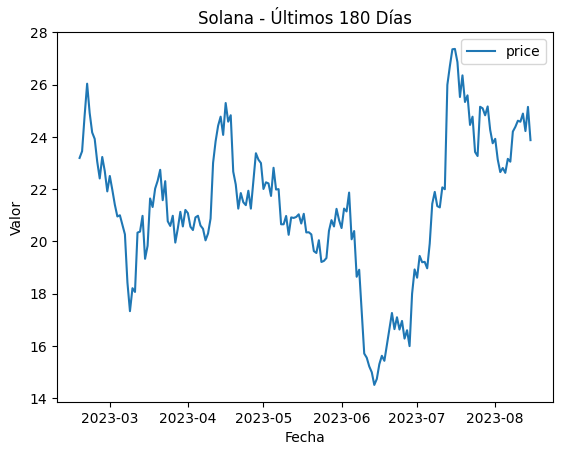

In [1315]:
# Ordenar el DataFrame por la columna 'date'
df_solana = df_solana.sort_values(by='date')

# Seleccionar los últimos 180 días de datos
last_180_days = df_solana.tail(180)

sns.lineplot(x='date', y='price', data=last_180_days, label='price')

# Configurar etiquetas y título
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.title('Solana - Últimos 180 Días')

plt.legend()
# Mostrar el gráfico
plt.show()

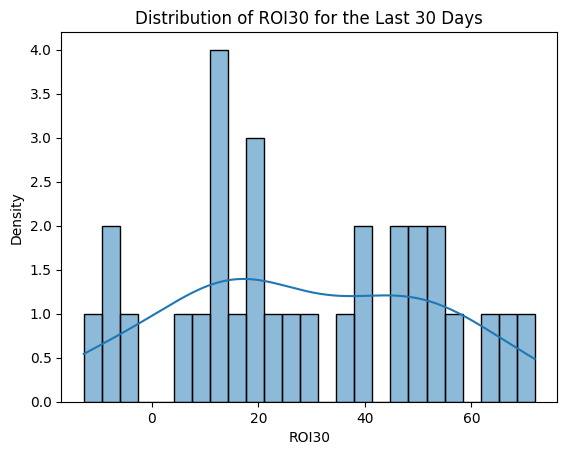

In [1316]:
# Filtrar los últimos 30 días del DataFrame
df_last_30_days = df_solana.tail(30)

# Crear un histplot en lugar de un distplot
sns.histplot(data=df_last_30_days, x='ROI30', bins=25, kde=True)

plt.xlabel('ROI30')
plt.ylabel('Density')
plt.title('Distribution of ROI30 for the Last 30 Days')

plt.show()

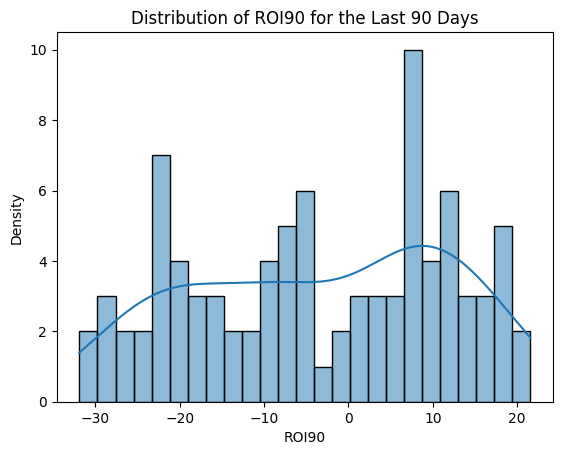

In [1317]:
# Filtrar los últimos 90 días del DataFrame
df_last_90_days = df_solana.tail(90)

# Crear un histplot en lugar de un distplot
sns.histplot(data=df_last_90_days, x='ROI90', bins=25, kde=True)

plt.xlabel('ROI90')
plt.ylabel('Density')
plt.title('Distribution of ROI90 for the Last 90 Days')

plt.show()

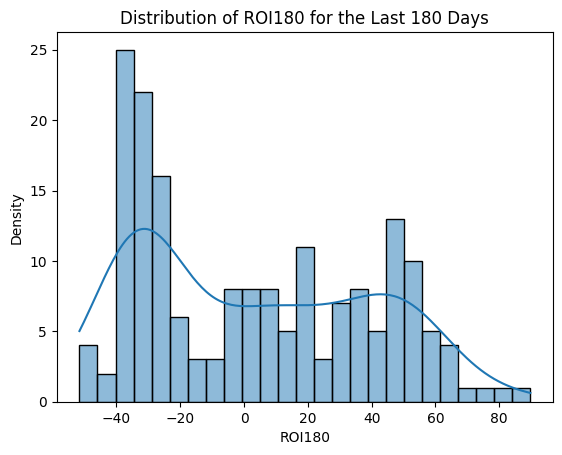

In [1318]:
# Filtrar los últimos 180 días del DataFrame
df_last_180_days = df_solana.tail(180)

# Crear un histplot en lugar de un distplot
sns.histplot(data=df_last_180_days, x='ROI180', bins=25, kde=True)

plt.xlabel('ROI180')
plt.ylabel('Density')
plt.title('Distribution of ROI180 for the Last 180 Days')

plt.show()

Conclusión: Esta moneda podría resultar conveniente para corto y mediano plazo.

7.b Bitcoin BTC

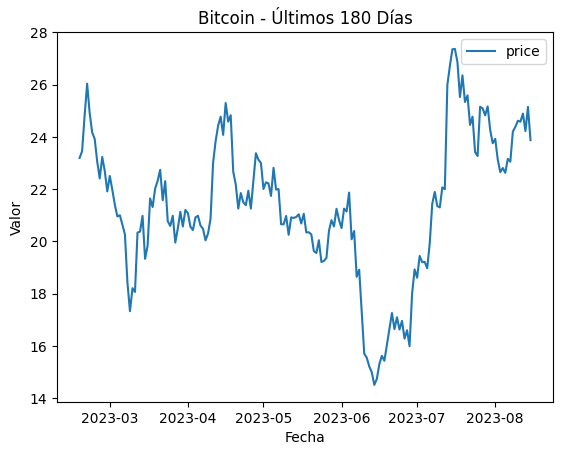

In [1319]:
# Ordenar el DataFrame por la columna 'date'
df_bitcoin = df_bitcoin.sort_values(by='date')

# Seleccionar los últimos 180 días de datos
last_180_days = df_solana.tail(180)

sns.lineplot(x='date', y='price', data=last_180_days, label='price')

# Configurar etiquetas y título
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.title('Bitcoin - Últimos 180 Días')

plt.legend()
# Mostrar el gráfico
plt.show()

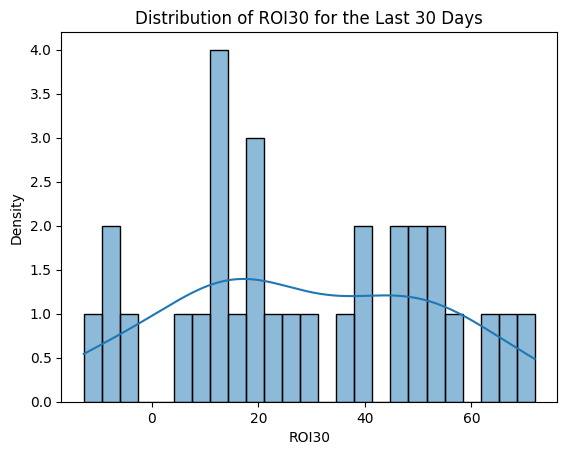

In [1320]:
# Filtrar los últimos 30 días del DataFrame
df_last_30_days = df_bitcoin.tail(30)

# Crear un histplot en lugar de un distplot
sns.histplot(data=df_last_30_days, x='ROI30', bins=25, kde=True)

plt.xlabel('ROI30')
plt.ylabel('Density')
plt.title('Distribution of ROI30 for the Last 30 Days')

plt.show()

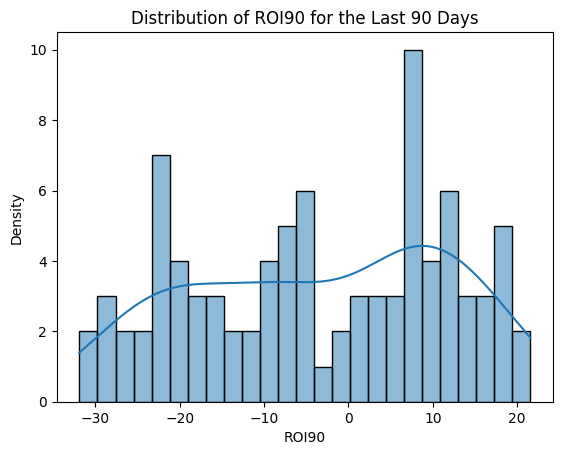

In [1321]:
# Filtrar los últimos 90 días del DataFrame
df_last_90_days = df_bitcoin.tail(90)

# Crear un histplot en lugar de un distplot
sns.histplot(data=df_last_90_days, x='ROI90', bins=25, kde=True)

plt.xlabel('ROI90')
plt.ylabel('Density')
plt.title('Distribution of ROI90 for the Last 90 Days')

plt.show()

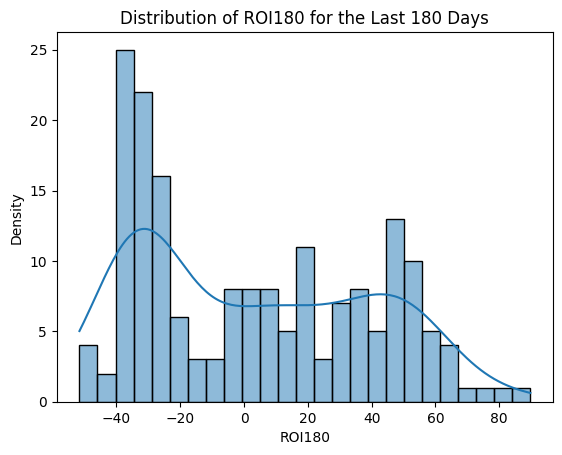

In [1322]:
# Filtrar los últimos 180 días del DataFrame
df_last_180_days = df_bitcoin.tail(180)

# Crear un histplot en lugar de un distplot
sns.histplot(data=df_last_180_days, x='ROI180', bins=25, kde=True)

plt.xlabel('ROI180')
plt.ylabel('Density')
plt.title('Distribution of ROI180 for the Last 180 Days')

plt.show()

Conclusión: Esta moneda podría resultar conveniente para corto y mediano plazo. A largo plazo puede llegar a presentar retornos interesantes.

7.c Tether USDT

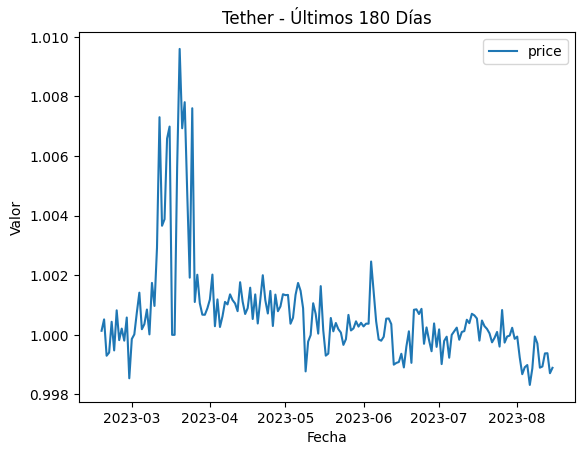

In [1323]:
# Ordenar el DataFrame por la columna 'date'
df_tether = df_tether.sort_values(by='date')

# Seleccionar los últimos 180 días de datos
last_180_days = df_tether.tail(180)

sns.lineplot(x='date', y='price', data=last_180_days, label='price')

# Configurar etiquetas y título
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.title('Tether - Últimos 180 Días')

plt.legend()
# Mostrar el gráfico
plt.show()

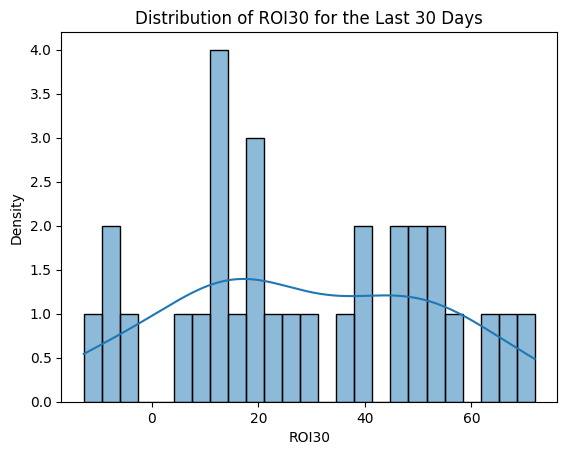

In [1324]:
# Filtrar los últimos 30 días del DataFrame
df_last_30_days = df_tether.tail(30)

# Crear un histplot en lugar de un distplot
sns.histplot(data=df_last_30_days, x='ROI30', bins=25, kde=True)

plt.xlabel('ROI30')
plt.ylabel('Density')
plt.title('Distribution of ROI30 for the Last 30 Days')

plt.show()

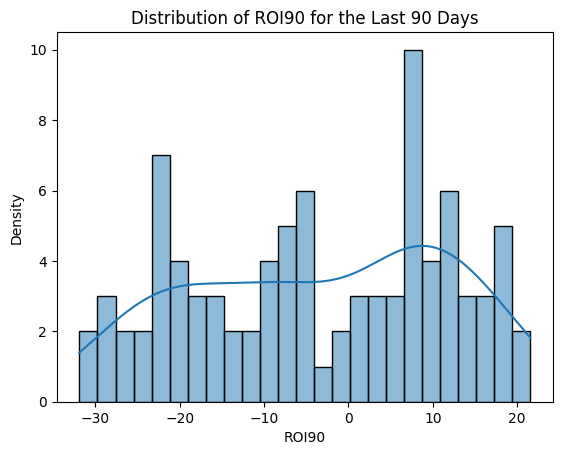

In [1325]:
# Filtrar los últimos 90 días del DataFrame
df_last_90_days = df_tether.tail(90)

# Crear un histplot en lugar de un distplot
sns.histplot(data=df_last_90_days, x='ROI90', bins=25, kde=True)

plt.xlabel('ROI90')
plt.ylabel('Density')
plt.title('Distribution of ROI90 for the Last 90 Days')

plt.show()

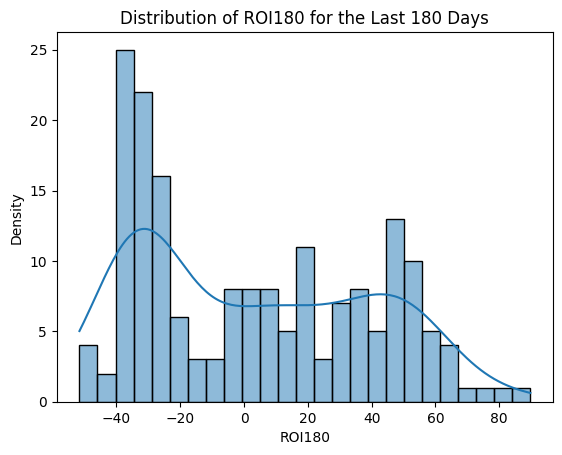

In [1326]:
# Filtrar los últimos 180 días del DataFrame
df_last_180_days = df_tether.tail(180)

# Crear un histplot en lugar de un distplot
sns.histplot(data=df_last_180_days, x='ROI180', bins=25, kde=True)

plt.xlabel('ROI180')
plt.ylabel('Density')
plt.title('Distribution of ROI180 for the Last 180 Days')

plt.show()

Conclusión: Esta moneda podría resultar conveniente para corto y mediano plazo.

7.d USD Coin USDC

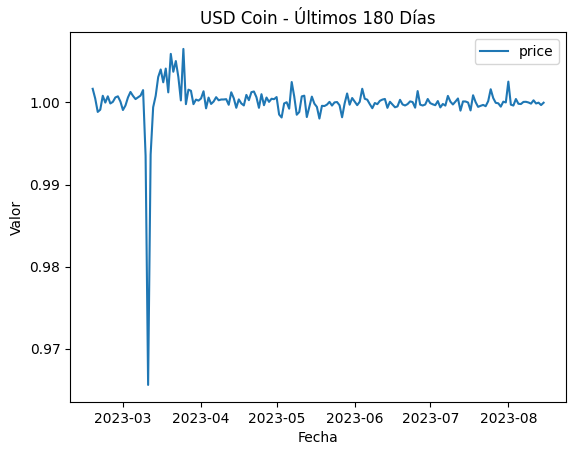

In [1327]:
# Ordenar el DataFrame por la columna 'date'
df_usd_coin = df_usd_coin.sort_values(by='date')

# Seleccionar los últimos 180 días de datos
last_180_days = df_usd_coin.tail(180)

sns.lineplot(x='date', y='price', data=last_180_days, label='price')

# Configurar etiquetas y título
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.title('USD Coin - Últimos 180 Días')

plt.legend()
# Mostrar el gráfico
plt.show()

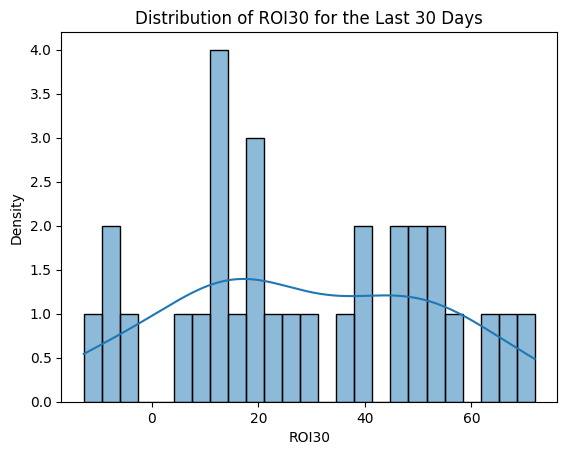

In [1328]:
# Filtrar los últimos 30 días del DataFrame
df_last_30_days = df_usd_coin.tail(30)

# Crear un histplot en lugar de un distplot
sns.histplot(data=df_last_30_days, x='ROI30', bins=25, kde=True)

plt.xlabel('ROI30')
plt.ylabel('Density')
plt.title('Distribution of ROI30 for the Last 30 Days')

plt.show()

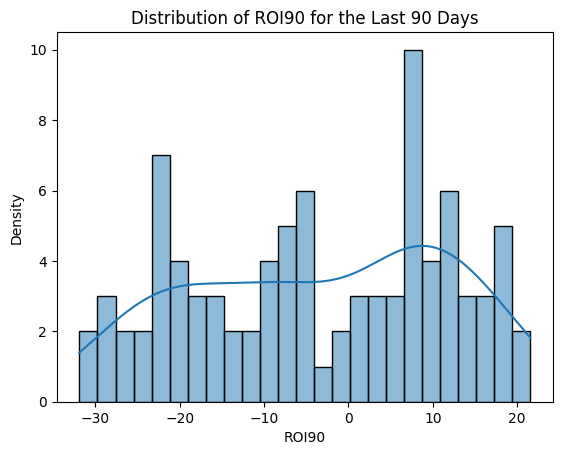

In [1329]:
# Filtrar los últimos 90 días del DataFrame
df_last_90_days = df_usd_coin.tail(90)

# Crear un histplot en lugar de un distplot
sns.histplot(data=df_last_90_days, x='ROI90', bins=25, kde=True)

plt.xlabel('ROI90')
plt.ylabel('Density')
plt.title('Distribution of ROI90 for the Last 90 Days')

plt.show()

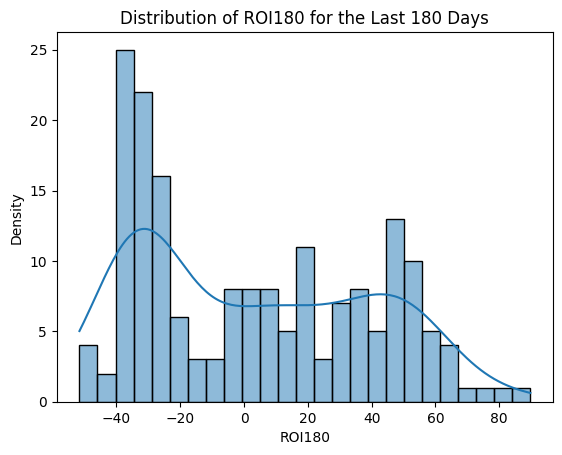

In [1330]:
# Filtrar los últimos 180 días del DataFrame
df_last_180_days = df_usd_coin.tail(180)

# Crear un histplot en lugar de un distplot
sns.histplot(data=df_last_180_days, x='ROI180', bins=25, kde=True)

plt.xlabel('ROI180')
plt.ylabel('Density')
plt.title('Distribution of ROI180 for the Last 180 Days')

plt.show()

Conclusión: Esta moneda podría resultar conveniente para corto y mediano plazo. A largo plazo puede llegar a presentar retornos interesantes.

7.e Ethereum ETH

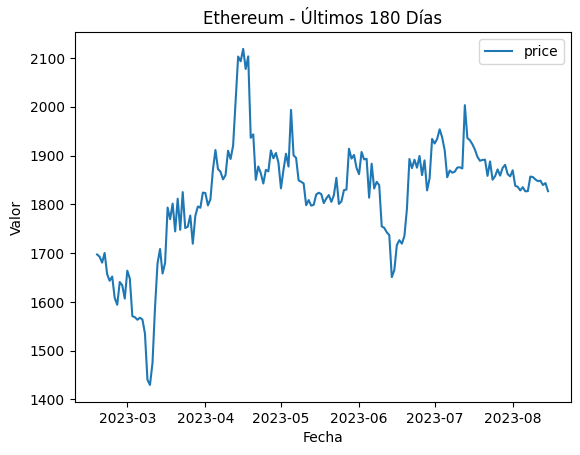

In [1331]:
# Ordenar el DataFrame por la columna 'date'
df_ethereum = df_ethereum.sort_values(by='date')

# Seleccionar los últimos 180 días de datos
last_180_days = df_ethereum.tail(180)

sns.lineplot(x='date', y='price', data=last_180_days, label='price')

# Configurar etiquetas y título
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.title('Ethereum - Últimos 180 Días')

plt.legend()
# Mostrar el gráfico
plt.show()

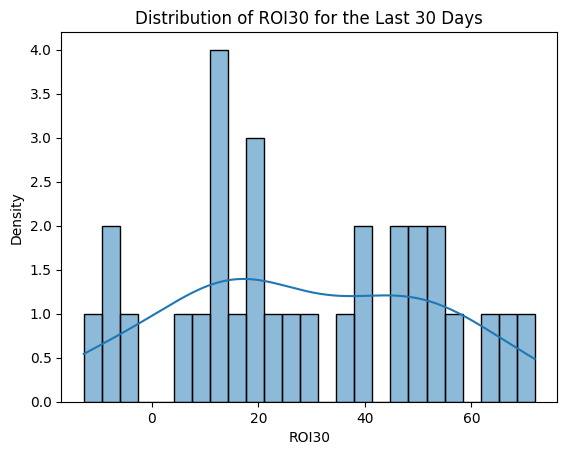

In [1332]:
# Filtrar los últimos 30 días del DataFrame
df_last_30_days = df_ethereum.tail(30)

# Crear un histplot en lugar de un distplot
sns.histplot(data=df_last_30_days, x='ROI30', bins=25, kde=True)

plt.xlabel('ROI30')
plt.ylabel('Density')
plt.title('Distribution of ROI30 for the Last 30 Days')

plt.show()

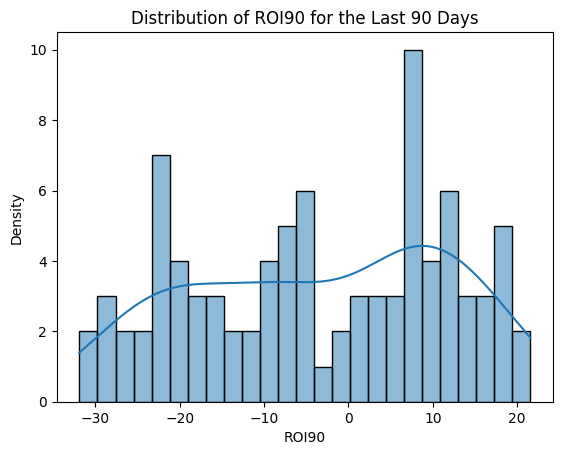

In [1333]:
# Filtrar los últimos 90 días del DataFrame
df_last_90_days = df_ethereum.tail(90)

# Crear un histplot en lugar de un distplot
sns.histplot(data=df_last_90_days, x='ROI90', bins=25, kde=True)

plt.xlabel('ROI90')
plt.ylabel('Density')
plt.title('Distribution of ROI90 for the Last 90 Days')

plt.show()

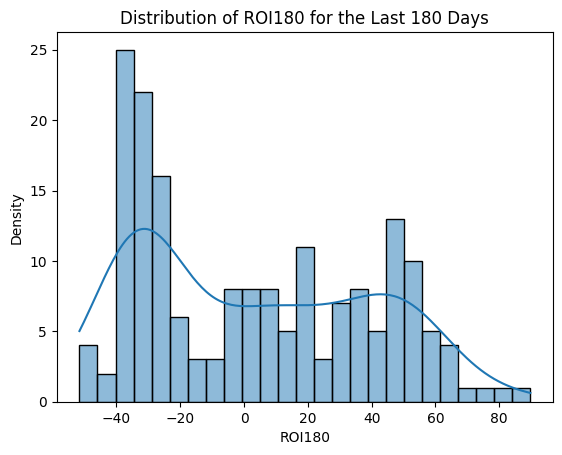

In [1334]:
# Filtrar los últimos 180 días del DataFrame
df_last_180_days = df_ethereum.tail(180)

# Crear un histplot en lugar de un distplot
sns.histplot(data=df_last_180_days, x='ROI180', bins=25, kde=True)

plt.xlabel('ROI180')
plt.ylabel('Density')
plt.title('Distribution of ROI180 for the Last 180 Days')

plt.show()

Conclusión: Esta moneda podría resultar conveniente para corto plazo. A mediano plazo presenta resultados ambiguos y largo plazo puede no llegar a brindar buenos resultados.

7.f Cardano ADA

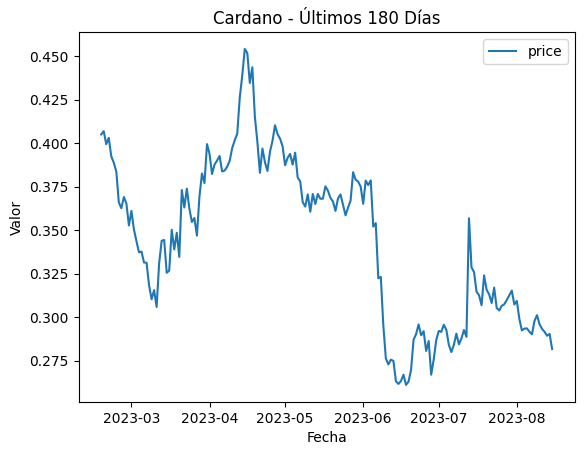

In [1335]:
# Ordenar el DataFrame por la columna 'date'
df_cardano = df_cardano.sort_values(by='date')

# Seleccionar los últimos 180 días de datos
last_180_days = df_cardano.tail(180)

sns.lineplot(x='date', y='price', data=last_180_days, label='price')

# Configurar etiquetas y título
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.title('Cardano - Últimos 180 Días')

plt.legend()
# Mostrar el gráfico
plt.show()

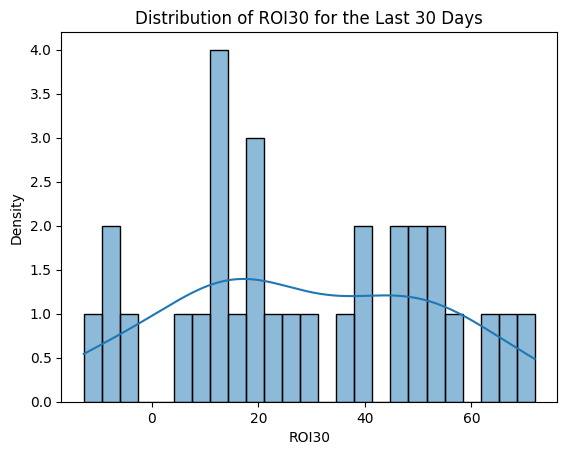

In [1336]:
# Filtrar los últimos 30 días del DataFrame
df_last_30_days = df_cardano.tail(30)

# Crear un histplot en lugar de un distplot
sns.histplot(data=df_last_30_days, x='ROI30', bins=25, kde=True)

plt.xlabel('ROI30')
plt.ylabel('Density')
plt.title('Distribution of ROI30 for the Last 30 Days')

plt.show()

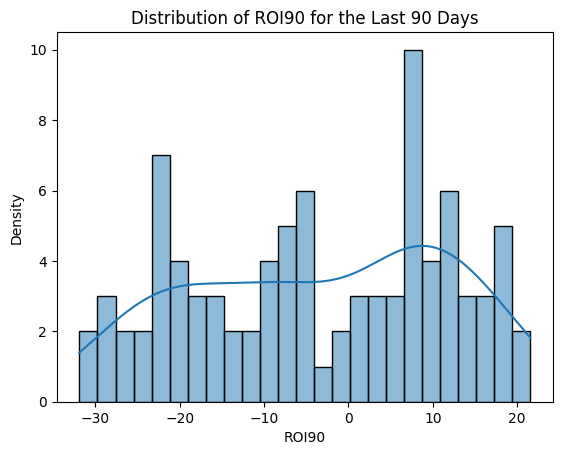

In [1337]:
# Filtrar los últimos 90 días del DataFrame
df_last_90_days = df_cardano.tail(90)

# Crear un histplot en lugar de un distplot
sns.histplot(data=df_last_90_days, x='ROI90', bins=25, kde=True)

plt.xlabel('ROI90')
plt.ylabel('Density')
plt.title('Distribution of ROI90 for the Last 90 Days')

plt.show()

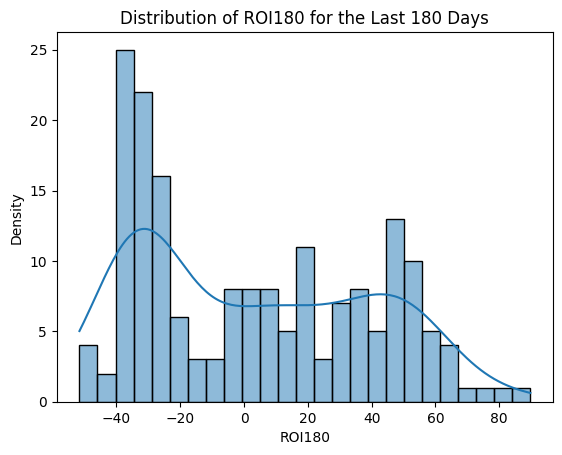

In [1338]:
# Filtrar los últimos 180 días del DataFrame
df_last_180_days = df_cardano.tail(180)

# Crear un histplot en lugar de un distplot
sns.histplot(data=df_last_180_days, x='ROI180', bins=25, kde=True)

plt.xlabel('ROI180')
plt.ylabel('Density')
plt.title('Distribution of ROI180 for the Last 180 Days')

plt.show()

Conclusión: Esta moneda podría resultar conveniente para corto plazo. A mediano plazo presenta resultados ambiguos y largo plazo puede no llegar a brindar buenos resultados.

7.g Avalanche AVAX

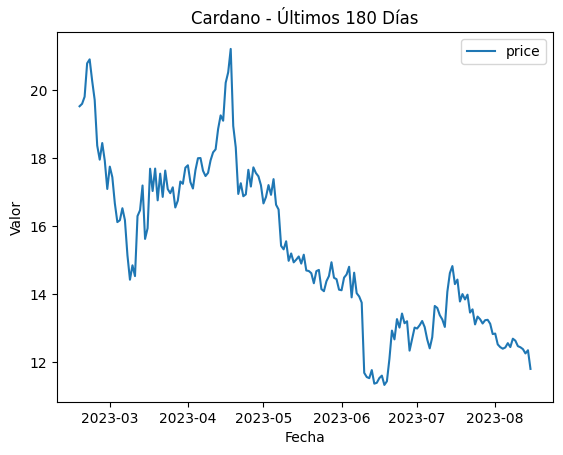

In [1339]:
# Ordenar el DataFrame por la columna 'date'
df_avalanche = df_avalanche.sort_values(by='date')

# Seleccionar los últimos 180 días de datos
last_180_days = df_avalanche.tail(180)

sns.lineplot(x='date', y='price', data=last_180_days, label='price')

# Configurar etiquetas y título
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.title('Cardano - Últimos 180 Días')

plt.legend()
# Mostrar el gráfico
plt.show()

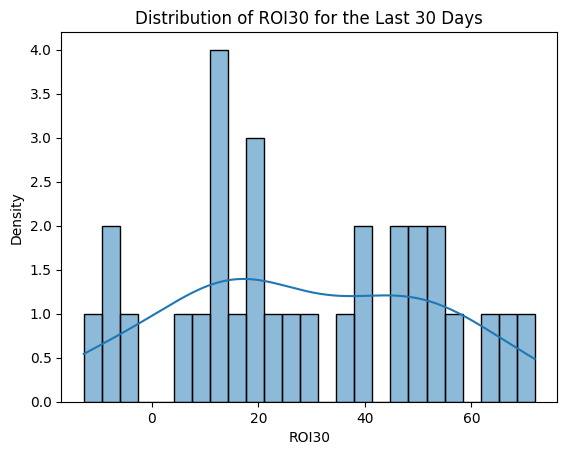

In [1340]:
# Filtrar los últimos 30 días del DataFrame
df_last_30_days = df_avalanche.tail(30)

# Crear un histplot en lugar de un distplot
sns.histplot(data=df_last_30_days, x='ROI30', bins=25, kde=True)

plt.xlabel('ROI30')
plt.ylabel('Density')
plt.title('Distribution of ROI30 for the Last 30 Days')

plt.show()

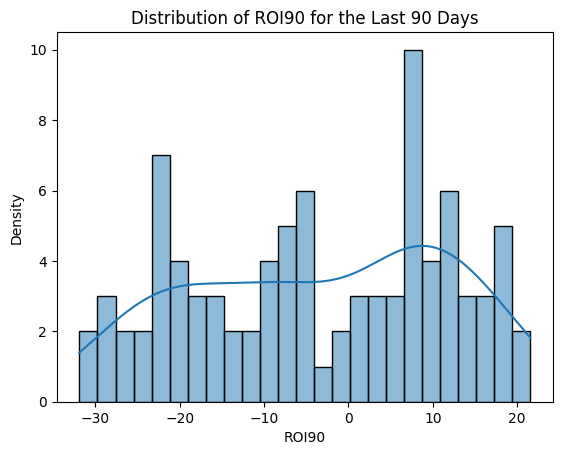

In [1341]:
# Filtrar los últimos 90 días del DataFrame
df_last_90_days = df_avalanche.tail(90)

# Crear un histplot en lugar de un distplot
sns.histplot(data=df_last_90_days, x='ROI90', bins=25, kde=True)

plt.xlabel('ROI90')
plt.ylabel('Density')
plt.title('Distribution of ROI90 for the Last 90 Days')

plt.show()

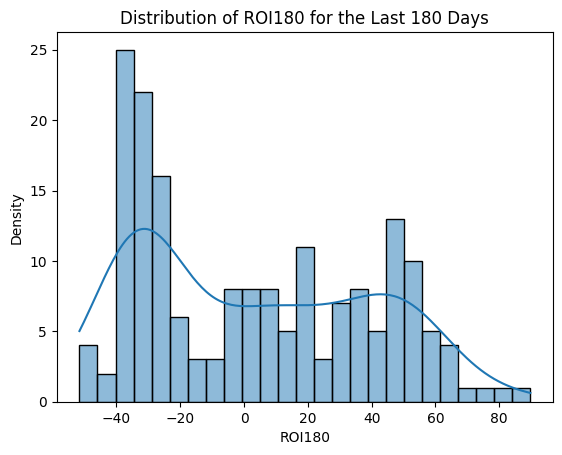

In [1342]:
# Filtrar los últimos 180 días del DataFrame
df_last_180_days = df_avalanche.tail(180)

# Crear un histplot en lugar de un distplot
sns.histplot(data=df_last_180_days, x='ROI180', bins=25, kde=True)

plt.xlabel('ROI180')
plt.ylabel('Density')
plt.title('Distribution of ROI180 for the Last 180 Days')

plt.show()

Conclusión: Esta moneda podría resultar conveniente para corto y mediano plazo.

7.h BNB BNB

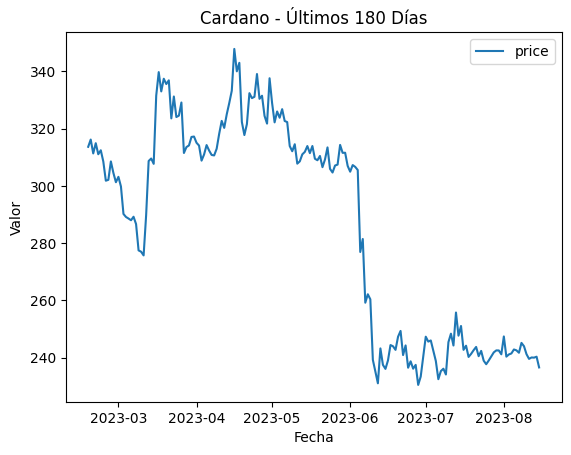

In [1343]:
# Ordenar el DataFrame por la columna 'date'
df_bnb = df_bnb.sort_values(by='date')

# Seleccionar los últimos 180 días de datos
last_180_days = df_bnb.tail(180)

sns.lineplot(x='date', y='price', data=last_180_days, label='price')

# Configurar etiquetas y título
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.title('Cardano - Últimos 180 Días')

plt.legend()
# Mostrar el gráfico
plt.show()

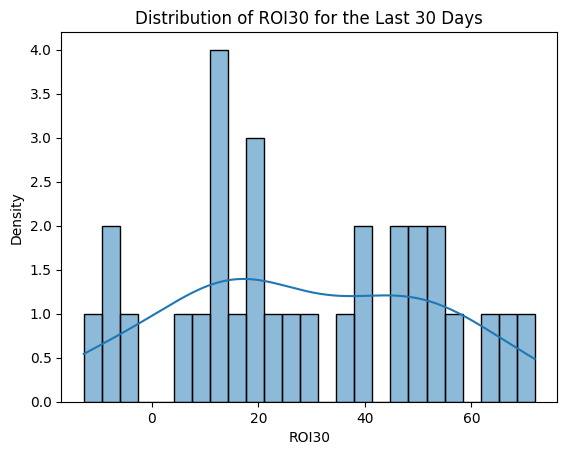

In [1344]:
# Filtrar los últimos 30 días del DataFrame
df_last_30_days = df_bnb.tail(30)

# Crear un histplot en lugar de un distplot
sns.histplot(data=df_last_30_days, x='ROI30', bins=25, kde=True)

plt.xlabel('ROI30')
plt.ylabel('Density')
plt.title('Distribution of ROI30 for the Last 30 Days')

plt.show()

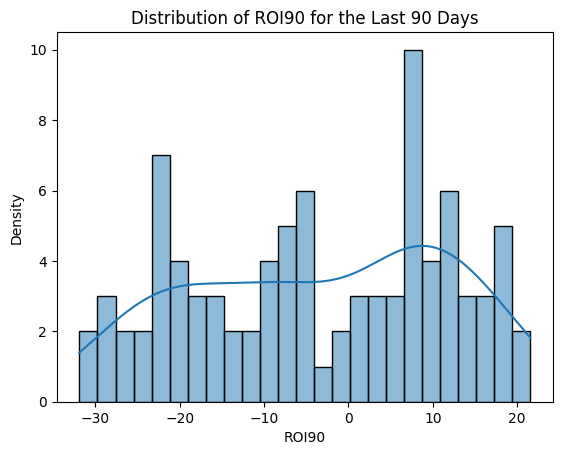

In [1345]:
# Filtrar los últimos 90 días del DataFrame
df_last_90_days = df_bnb.tail(90)

# Crear un histplot en lugar de un distplot
sns.histplot(data=df_last_90_days, x='ROI90', bins=25, kde=True)

plt.xlabel('ROI90')
plt.ylabel('Density')
plt.title('Distribution of ROI90 for the Last 90 Days')

plt.show()

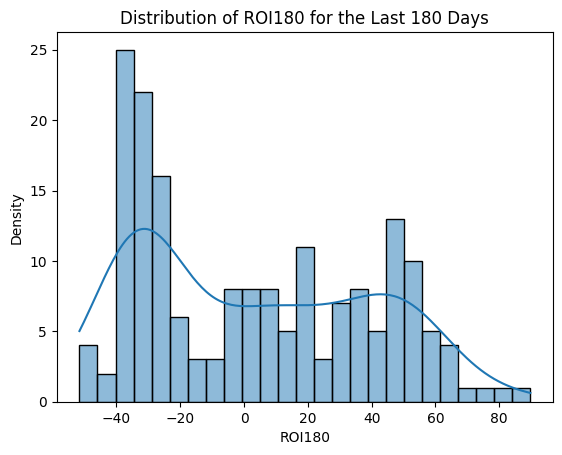

In [1346]:
# Filtrar los últimos 180 días del DataFrame
df_last_180_days = df_bnb.tail(180)

# Crear un histplot en lugar de un distplot
sns.histplot(data=df_last_180_days, x='ROI180', bins=25, kde=True)

plt.xlabel('ROI180')
plt.ylabel('Density')
plt.title('Distribution of ROI180 for the Last 180 Days')

plt.show()

Conclusión: Esta moneda podría resultar conveniente para corto y mediano plazo. A largo plazo puede no llegar a presentar retornos interesantes.

7.i Dogecoin DOGE

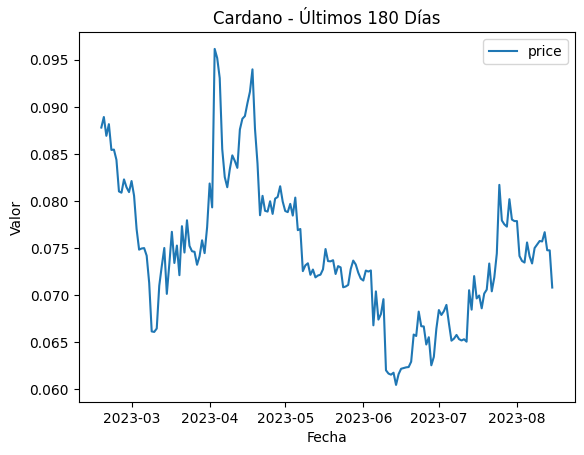

In [1347]:
# Ordenar el DataFrame por la columna 'date'
df_dogecoin = df_dogecoin.sort_values(by='date')

# Seleccionar los últimos 180 días de datos
last_180_days = df_dogecoin.tail(180)

sns.lineplot(x='date', y='price', data=last_180_days, label='price')

# Configurar etiquetas y título
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.title('Cardano - Últimos 180 Días')

plt.legend()
# Mostrar el gráfico
plt.show()

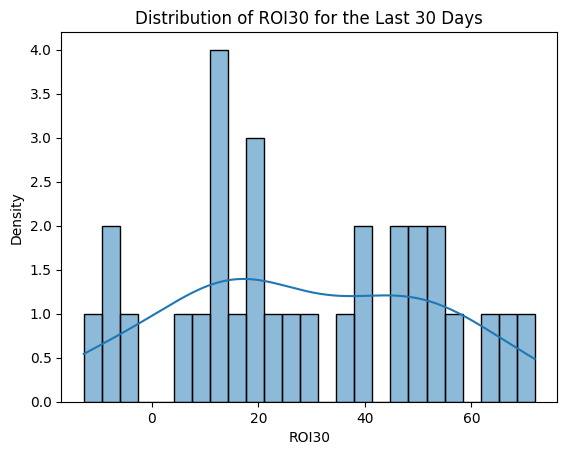

In [1348]:
# Filtrar los últimos 30 días del DataFrame
df_last_30_days = df_dogecoin.tail(30)

# Crear un histplot en lugar de un distplot
sns.histplot(data=df_last_30_days, x='ROI30', bins=25, kde=True)

plt.xlabel('ROI30')
plt.ylabel('Density')
plt.title('Distribution of ROI30 for the Last 30 Days')

plt.show()

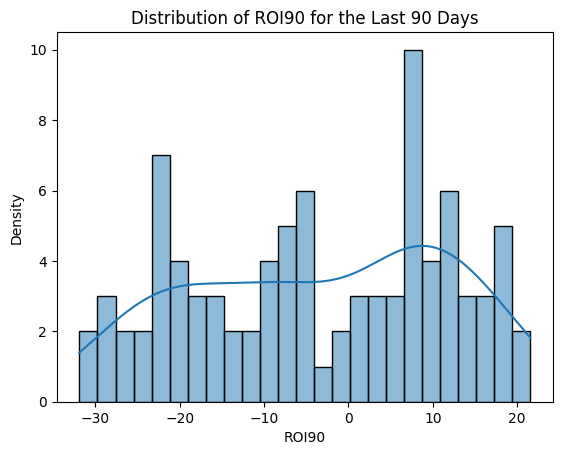

In [1349]:
# Filtrar los últimos 90 días del DataFrame
df_last_90_days = df_dogecoin.tail(90)

# Crear un histplot en lugar de un distplot
sns.histplot(data=df_last_90_days, x='ROI90', bins=25, kde=True)

plt.xlabel('ROI90')
plt.ylabel('Density')
plt.title('Distribution of ROI90 for the Last 90 Days')

plt.show()

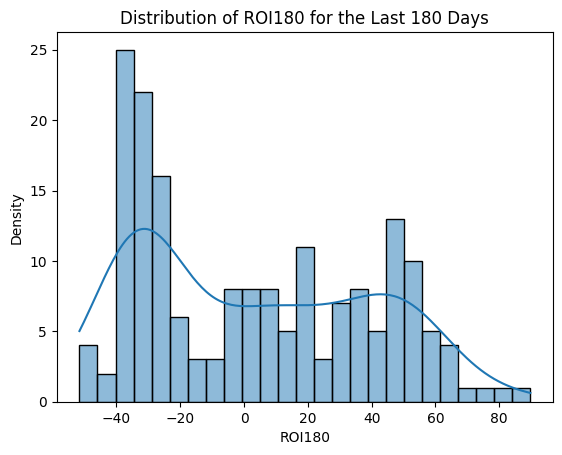

In [1350]:
# Filtrar los últimos 180 días del DataFrame
df_last_180_days = df_dogecoin.tail(180)

# Crear un histplot en lugar de un distplot
sns.histplot(data=df_last_180_days, x='ROI180', bins=25, kde=True)

plt.xlabel('ROI180')
plt.ylabel('Density')
plt.title('Distribution of ROI180 for the Last 180 Days')

plt.show()

Conclusión: Esta moneda podría resultar conveniente para corto y mediano plazo.

7.j EOS EOS

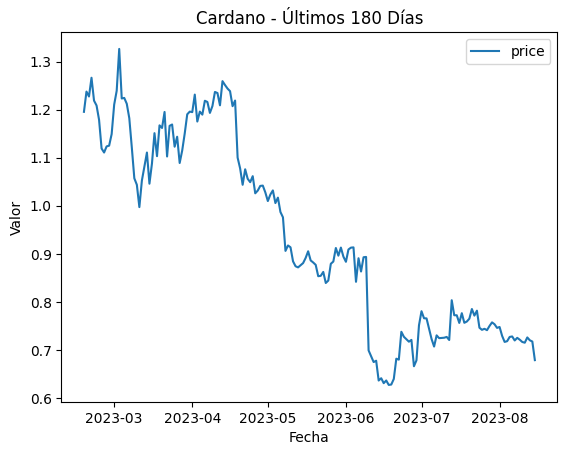

In [1351]:
# Ordenar el DataFrame por la columna 'date'
df_eos = df_eos.sort_values(by='date')

# Seleccionar los últimos 180 días de datos
last_180_days = df_eos.tail(180)

sns.lineplot(x='date', y='price', data=last_180_days, label='price')

# Configurar etiquetas y título
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.title('Cardano - Últimos 180 Días')

plt.legend()
# Mostrar el gráfico
plt.show()

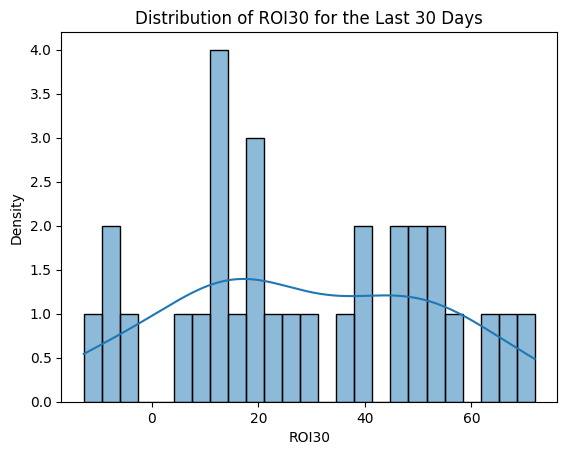

In [1352]:
# Filtrar los últimos 30 días del DataFrame
df_last_30_days = df_eos.tail(30)

# Crear un histplot en lugar de un distplot
sns.histplot(data=df_last_30_days, x='ROI30', bins=25, kde=True)

plt.xlabel('ROI30')
plt.ylabel('Density')
plt.title('Distribution of ROI30 for the Last 30 Days')

plt.show()

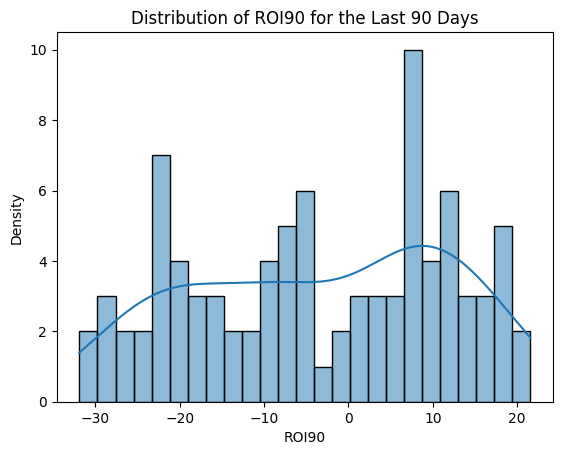

In [1353]:
# Filtrar los últimos 90 días del DataFrame
df_last_90_days = df_eos.tail(90)

# Crear un histplot en lugar de un distplot
sns.histplot(data=df_last_90_days, x='ROI90', bins=25, kde=True)

plt.xlabel('ROI90')
plt.ylabel('Density')
plt.title('Distribution of ROI90 for the Last 90 Days')

plt.show()

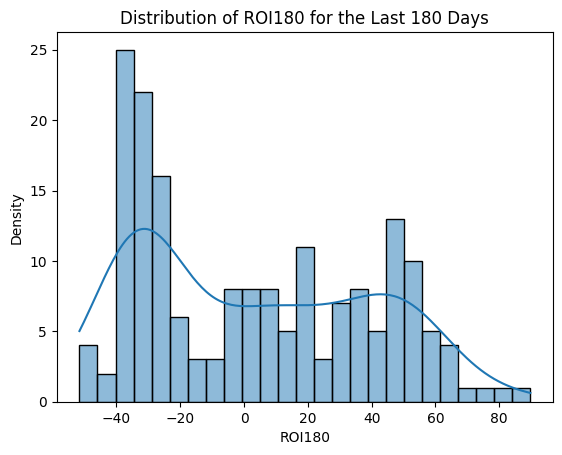

In [1354]:
# Filtrar los últimos 180 días del DataFrame
df_last_180_days = df_eos.tail(180)

# Crear un histplot en lugar de un distplot
sns.histplot(data=df_last_180_days, x='ROI180', bins=25, kde=True)

plt.xlabel('ROI180')
plt.ylabel('Density')
plt.title('Distribution of ROI180 for the Last 180 Days')

plt.show()

Conclusión: Esta moneda podría resultar conveniente para corto y mediano plazo.